### Обучение моделей

Ниже проводится обучение и оценка качества моделей на подвыборках датасета с фиксированным числом признаков.
Реализованы классические модели Random Forest, XGBoost, LightGBM, CatBoost, Logistic Regression и модель TabNet.
Для каждой модели вычисляются метрики Accuracy, F1-score, AUC-ROC,
а также измеряется время обучения и предсказания.
Результаты и матрицы ошибок сохраняются для дальнейшего анализа.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import torch
from scipy.special import softmax
from pytorch_tabnet.abstract_model import TabModel
from pytorch_tabnet.utils import SparsePredictDataset, PredictDataset
from pytorch_tabnet.multiclass_utils import infer_output_dim, check_output_dim
from torch.utils.data import DataLoader
import scipy
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display, Markdown
from tabulate import tabulate
import os

class TabNetClassifier(TabModel):
    def __post_init__(self):
        super(TabNetClassifier, self).__post_init__()
        self._task = 'classification'
        self._default_loss = torch.nn.functional.cross_entropy
        self._default_metric = 'accuracy'

    def weight_updater(self, weights):
        if isinstance(weights, int):
            return weights
        elif isinstance(weights, dict):
            return {self.target_mapper[key]: value for key, value in weights.items()}
        else:
            return weights

    def prepare_target(self, y):
        return np.vectorize(self.target_mapper.get)(y)

    def compute_loss(self, y_pred, y_true):
        return self.loss_fn(y_pred, y_true.long())

    def update_fit_params(self, X_train, y_train, eval_set, weights):
        output_dim, train_labels = infer_output_dim(y_train)
        for X, y in eval_set:
            check_output_dim(train_labels, y)
        self.output_dim = output_dim
        self._default_metric = ('auc' if self.output_dim == 2 else 'accuracy')
        self.classes_ = train_labels
        self.target_mapper = {class_label: index for index, class_label in enumerate(self.classes_)}
        self.preds_mapper = {str(index): class_label for index, class_label in enumerate(self.classes_)}
        self.updated_weights = self.weight_updater(weights)

    def stack_batches(self, list_y_true, list_y_score):
        y_true = np.hstack(list_y_true)
        y_score = np.vstack(list_y_score)
        y_score = softmax(y_score, axis=1)
        return y_true, y_score

    def predict_func(self, outputs):
        outputs = np.argmax(outputs, axis=1)
        return np.vectorize(self.preds_mapper.get)(outputs.astype(str))

    def predict_proba(self, X):
        self.network.eval()
        if scipy.sparse.issparse(X):
            dataloader = DataLoader(SparsePredictDataset(X), batch_size=self.batch_size, shuffle=False)
        else:
            dataloader = DataLoader(PredictDataset(X), batch_size=self.batch_size, shuffle=False)

        results = []
        for batch_nb, data in enumerate(dataloader):
            data = data.to(self.device).float()
            output, M_loss = self.network(data)
            predictions = torch.nn.Softmax(dim=1)(output).cpu().detach().numpy()
            results.append(predictions)
        return np.vstack(results)

def train_and_evaluate_classical_models(X_train, y_train, X_test, y_test):
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=123),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                             n_estimators=100, subsample=0.8, colsample_bytree=0.8, 
                             n_jobs=-1, random_state=123),
        "LightGBM": LGBMClassifier(n_estimators=100, subsample=0.8, colsample_bytree=0.8, 
                               n_jobs=-1, random_state=123),
        "CatBoost": CatBoostClassifier(n_estimators=100, subsample=0.8, colsample_bylevel=0.8, 
                                   verbose=0, random_state=123),
        "Logistic Regression": LogisticRegression(max_iter=500, solver="saga", n_jobs=-1, random_state=123)
    }
    
    results = {}
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        start_time = time.time()
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        prediction_time = time.time() - start_time
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        
        results[model_name] = {
            "accuracy": accuracy,
            "f1_score": f1,
            "auc_roc": auc_roc,
            "training_time": training_time,
            "prediction_time": prediction_time,
            "confusion_matrix": cm
        }
        
        print(f"{model_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc_roc:.4f}" if auc_roc is not None else "AUC-ROC: Not available")
        print(f"Training Time: {training_time:.2f} seconds")
        print(f"Prediction Time: {prediction_time:.4f} seconds")
        print("Confusion Matrix:")
        print(cm)
        print("-" * 50)
    
    return results

files_1 = [
    'data_subsets_higgs/subset_10000_features_434.csv', 
    'data_subsets_higgs/subset_50000_features_434.csv', 
    'data_subsets_higgs/subset_100000_features_434.csv',
    'data_subsets_higgs/subset_500000_features_434.csv',
    'data_subsets_higgs/subset_997646_features_434.csv'
]

files_2 = [
    'data_subsets_higgs/subset_10000_features_10.csv', 
    'data_subsets_higgs/subset_10000_features_50.csv', 
    'data_subsets_higgs/subset_10000_features_100.csv', 
    'data_subsets_higgs/subset_10000_features_200.csv', 
    'data_subsets_higgs/subset_10000_features_434.csv',
    'data_subsets_higgs/subset_50000_features_10.csv', 
    'data_subsets_higgs/subset_50000_features_50.csv', 
    'data_subsets_higgs/subset_50000_features_100.csv', 
    'data_subsets_higgs/subset_50000_features_200.csv', 
    'data_subsets_higgs/subset_50000_features_434.csv',
    'data_subsets_higgs/subset_100000_features_10.csv', 
    'data_subsets_higgs/subset_100000_features_50.csv', 
    'data_subsets_higgs/subset_100000_features_100.csv', 
    'data_subsets_higgs/subset_100000_features_200.csv', 
    'data_subsets_higgs/subset_100000_features_434.csv',
    'data_subsets_higgs/subset_500000_features_10.csv',
    'data_subsets_higgs/subset_500000_features_50.csv',
    'data_subsets_higgs/subset_500000_features_100.csv',
    'data_subsets_higgs/subset_500000_features_200.csv',
    'data_subsets_higgs/subset_500000_features_434.csv',
    'data_subsets_higgs/subset_997646_features_10.csv',
    'data_subsets_higgs/subset_997646_features_50.csv',
    'data_subsets_higgs/subset_997646_features_100.csv',
    'data_subsets_higgs/subset_997646_features_200.csv',
    'data_subsets_higgs/subset_997646_features_434.csv',
]

all_results = {}

# Цикл для фиксированного числа признаков
for file in files_1:
    print(f"Processing file: {file}")
    
    data_1 = pd.read_csv(file)
    
    data_1.columns = data_1.columns.str.replace(" ", "_")
    
    X_1 = data_1.drop(columns=["target"])
    y_1 = data_1["target"]
    
    X_train_1, X_temp_1, y_train_1, y_temp_1 = train_test_split(
        X_1, y_1, test_size=0.3, random_state=123, stratify=y_1
    )
    X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(
        X_temp_1, y_temp_1, test_size=0.5, random_state=123, stratify=y_temp_1
    )
    
    X_train_np_1 = X_train_1.values
    X_val_np_1 = X_val_1.values
    X_test_np_1 = X_test_1.values
    y_train_np_1 = y_train_1
    y_val_np_1 = y_val_1
    y_test_np_1 = y_test_1
    
    # Обучаем классические модели
    classical_results_1 = train_and_evaluate_classical_models(
    X_train_np_1, y_train_np_1, X_test_np_1, y_test_np_1
    )
    
    # Сохраняем результаты
    for model_name, result in classical_results_1.items():
        all_results[f"{model_name}_{file}"] = result
    
    # Обучаем TabNet    
    tabnet_model_1 = TabNetClassifier(
        n_d=16, n_a=16, n_steps=3, gamma=1.7, lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler_params={"mode": "max", "patience": 5, "min_lr": 1e-5, "factor": 0.5}
    )    
    
    # Замеряем время обучения
    start_time = time.time()
    
    tabnet_model_1.fit(
        X_train=X_train_np_1, y_train=y_train_np_1,
        eval_set=[(X_val_np_1, y_val_np_1)],
        eval_name=["val"],
        eval_metric=["auc"],
        max_epochs=20,
        patience=10,
        batch_size=2048,
        virtual_batch_size=256
    )
    
    training_time_1 = time.time() - start_time
    print(f"Общее время обучения TabNet: {training_time_1:.2f} секунд")
    
    # Замеряем время предсказания
    start_time = time.time()
    y_pred_proba_1 = tabnet_model_1.predict_proba(X_test_np_1)
    y_pred_proba_pos_1 = y_pred_proba_1[:, 1]
    y_pred_1 = np.argmax(y_pred_proba_1, axis=1)
    cm_tabnet_1 = confusion_matrix(y_test_np_1, y_pred_1)
    prediction_time_1 = time.time() - start_time
    
    # Метрики
    accuracy_1 = accuracy_score(y_test_np_1, y_pred_1)
    f1_1 = f1_score(y_test_np_1, y_pred_1, average='weighted')
    auc_roc_1 = roc_auc_score(y_test_np_1, y_pred_proba_pos_1)
    
    # Сохранение результатов TabNet
    all_results[f"TabNet_{file}"] = {
        "accuracy": accuracy_1,
        "f1_score": f1_1,
        "auc_roc": auc_roc_1,
        "training_time": training_time_1,
        "prediction_time": prediction_time_1,
        "confusion_matrix": cm_tabnet_1
    }
    
    print(f"TabNet Results:")
    print(f"Accuracy: {accuracy_1:.4f}")
    print(f"F1-Score: {f1_1:.4f}")
    print(f"AUC-ROC: {auc_roc_1:.4f}")
    print(f"Prediction Time: {prediction_time_1:.4f} seconds")
    print("Confusion Matrix (TabNet):")
    print(cm_tabnet_1)
    print("-" * 50)

Processing file: data_subsets_higgs/subset_10000_features_434.csv
Training Random Forest...
Random Forest Results:
Accuracy: 0.6647
F1-Score: 0.6649
AUC-ROC: 0.7350
Training Time: 1.07 seconds
Prediction Time: 0.0137 seconds
Confusion Matrix:
[[482 225]
 [278 515]]
--------------------------------------------------
Training XGBoost...
XGBoost Results:
Accuracy: 0.6800
F1-Score: 0.6796
AUC-ROC: 0.7480
Training Time: 1.70 seconds
Prediction Time: 0.0033 seconds
Confusion Matrix:
[[454 253]
 [227 566]]
--------------------------------------------------
Training LightGBM...
[LightGBM] [Info] Number of positive: 3703, number of negative: 3297
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107192
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 434
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529000 -> ini

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.6967
F1-Score: 0.6967
AUC-ROC: 0.7660
Training Time: 1.37 seconds
Prediction Time: 0.0086 seconds
Confusion Matrix:
[[479 228]
 [227 566]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.6907
F1-Score: 0.6906
AUC-ROC: 0.7541
Training Time: 1.62 seconds
Prediction Time: 0.0048 seconds
Confusion Matrix:
[[471 236]
 [228 565]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6807
F1-Score: 0.6792
AUC-ROC: 0.7363
Training Time: 5.75 seconds
Prediction Time: 0.0019 seconds
Confusion Matrix:
[[434 273]
 [206 587]]
--------------------------------------------------
epoch 0  | loss: 0.96158 | val_auc: 0.46686 |  0:00:00s
epoch 1  | loss: 0.78125 | val_auc: 0.49199 |  0:00:00s
epoch 2  | loss: 0.73898 | val_auc: 0.51246 |  0:00:00s
epoch 3  | loss: 0.7109  | val_auc: 0.5185  |  0:00:01s
epoch 4  | loss: 0.70079 | val_auc: 0.52368 |  0:00:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 18523, number of negative: 16477
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107192
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 434
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529229 -> initscore=0.117048
[LightGBM] [Info] Start training from score 0.117048


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7193
F1-Score: 0.7191
AUC-ROC: 0.7985
Training Time: 1.87 seconds
Prediction Time: 0.0373 seconds
Confusion Matrix:
[[2438 1093]
 [1012 2957]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7007
F1-Score: 0.7006
AUC-ROC: 0.7747
Training Time: 2.20 seconds
Prediction Time: 0.0099 seconds
Confusion Matrix:
[[2388 1143]
 [1102 2867]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6865
F1-Score: 0.6851
AUC-ROC: 0.7463
Training Time: 30.55 seconds
Prediction Time: 0.0048 seconds
Confusion Matrix:
[[2194 1337]
 [1014 2955]]
--------------------------------------------------
epoch 0  | loss: 0.7829  | val_auc: 0.51135 |  0:00:01s
epoch 1  | loss: 0.6951  | val_auc: 0.52951 |  0:00:03s
epoch 2  | loss: 0.68879 | val_auc: 0.57209 |  0:00:04s
epoch 3  | loss: 0.6823  | val_auc: 0.59396 |  0:00:06s
epoch 4  | loss: 0.67295 | val_auc: 0.6

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 37029, number of negative: 32971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107192
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 434
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528986 -> initscore=0.116073
[LightGBM] [Info] Start training from score 0.116073


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7238
F1-Score: 0.7236
AUC-ROC: 0.8067
Training Time: 3.55 seconds
Prediction Time: 0.0625 seconds
Confusion Matrix:
[[4930 2135]
 [2008 5927]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7215
F1-Score: 0.7213
AUC-ROC: 0.7941
Training Time: 3.09 seconds
Prediction Time: 0.0169 seconds
Confusion Matrix:
[[4894 2171]
 [2006 5929]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6977
F1-Score: 0.6963
AUC-ROC: 0.7578
Training Time: 61.75 seconds
Prediction Time: 0.0087 seconds
Confusion Matrix:
[[4451 2614]
 [1920 6015]]
--------------------------------------------------
epoch 0  | loss: 0.73896 | val_auc: 0.56356 |  0:00:03s
epoch 1  | loss: 0.67635 | val_auc: 0.62108 |  0:00:06s
epoch 2  | loss: 0.66299 | val_auc: 0.64755 |  0:00:09s
epoch 3  | loss: 0.66033 | val_auc: 0.6462  |  0:00:13s
epoch 4  | loss: 0.65768 | val_auc: 0.6

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 185653, number of negative: 164347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107192
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 434
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530437 -> initscore=0.121899
[LightGBM] [Info] Start training from score 0.121899


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7337
F1-Score: 0.7336
AUC-ROC: 0.8141
Training Time: 15.70 seconds
Prediction Time: 0.4191 seconds
Confusion Matrix:
[[25043 10175]
 [ 9801 29981]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7355
F1-Score: 0.7354
AUC-ROC: 0.8158
Training Time: 8.50 seconds
Prediction Time: 0.0583 seconds
Confusion Matrix:
[[24970 10248]
 [ 9587 30195]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6995
F1-Score: 0.6980
AUC-ROC: 0.7650
Training Time: 326.26 seconds
Prediction Time: 0.1074 seconds
Confusion Matrix:
[[22238 12980]
 [ 9560 30222]]
--------------------------------------------------
epoch 0  | loss: 0.68194 | val_auc: 0.65204 |  0:00:17s
epoch 1  | loss: 0.6541  | val_auc: 0.67005 |  0:00:34s
epoch 2  | loss: 0.64685 | val_auc: 0.67614 |  0:00:51s
epoch 3  | loss: 0.64317 | val_auc: 0.68225 |  0:01:07s
epoch 4  | loss: 0.64149 

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 370750, number of negative: 327602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.430736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107192
[LightGBM] [Info] Number of data points in the train set: 698352, number of used features: 434
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530893 -> initscore=0.123729
[LightGBM] [Info] Start training from score 0.123729


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7342
F1-Score: 0.7340
AUC-ROC: 0.8150
Training Time: 36.34 seconds
Prediction Time: 1.8066 seconds
Confusion Matrix:
[[49695 20506]
 [19271 60175]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7375
F1-Score: 0.7373
AUC-ROC: 0.8186
Training Time: 16.46 seconds
Prediction Time: 0.0991 seconds
Confusion Matrix:
[[49811 20390]
 [18896 60550]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7022
F1-Score: 0.7006
AUC-ROC: 0.7675
Training Time: 772.01 seconds
Prediction Time: 1.2816 seconds
Confusion Matrix:
[[44310 25891]
 [18673 60773]]
--------------------------------------------------
epoch 0  | loss: 0.66452 | val_auc: 0.67019 |  0:00:38s
epoch 1  | loss: 0.64788 | val_auc: 0.67678 |  0:01:14s
epoch 2  | loss: 0.6433  | val_auc: 0.686   |  0:01:50s
epoch 3  | loss: 0.63361 | val_auc: 0.6986  |  0:02:25s
epoch 4  | loss: 0.61747

### Визуализация результатов (files_1)

Построены:
- матрицы ошибок 
- графики Accuracy, F1-score, AUC-ROC,времени обучения и времени предсказания

CONFUSION MATRICES: files_1


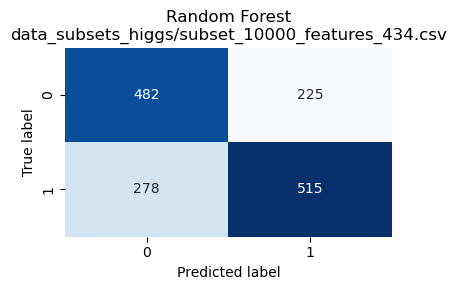

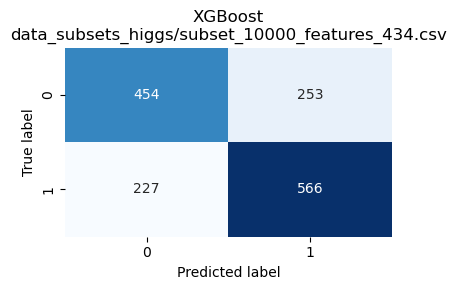

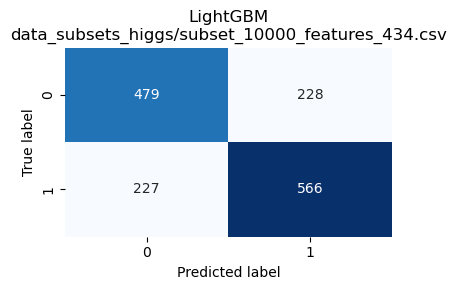

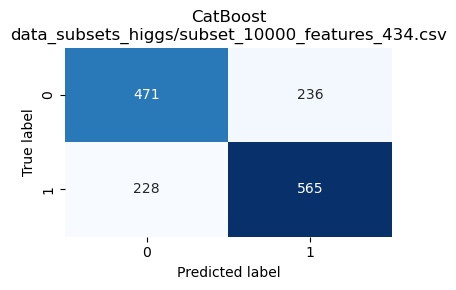

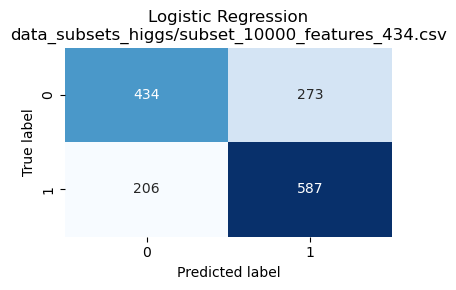

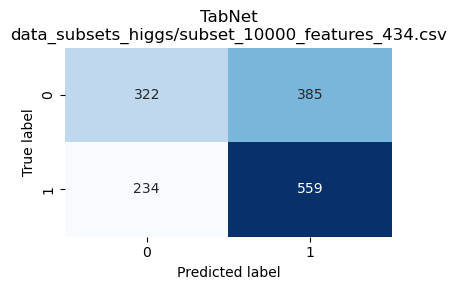

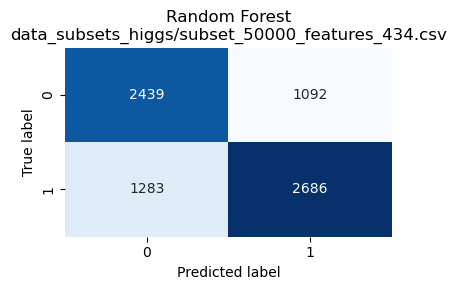

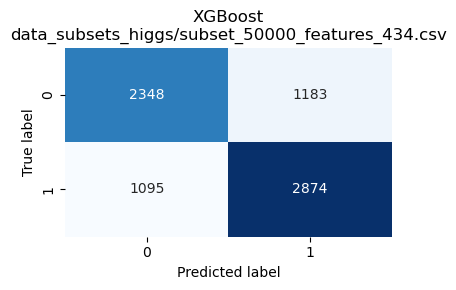

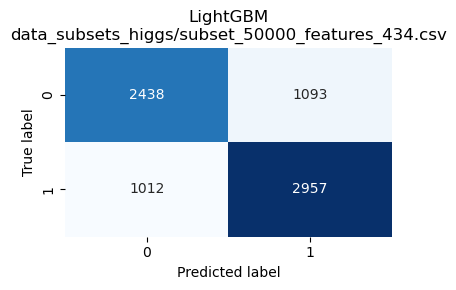

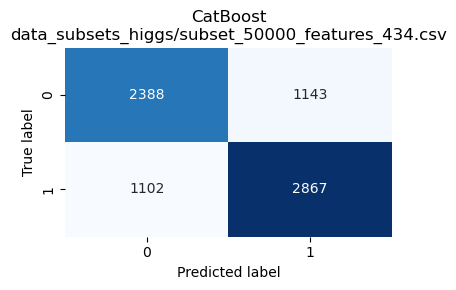

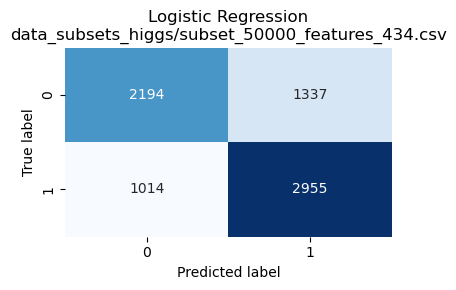

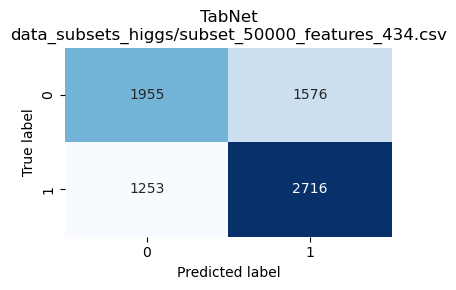

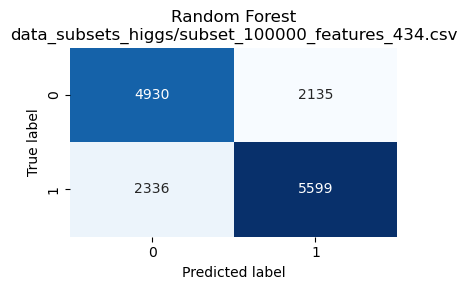

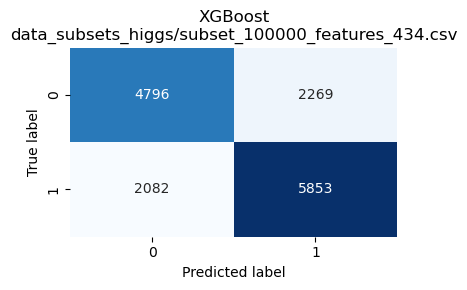

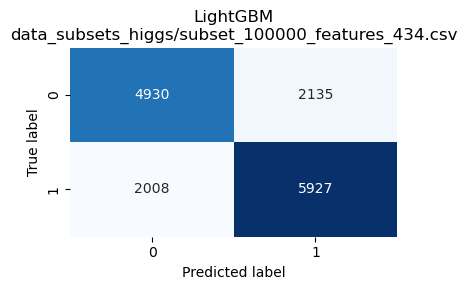

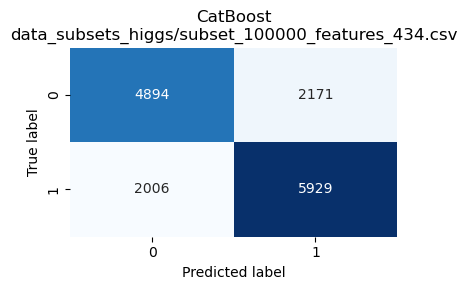

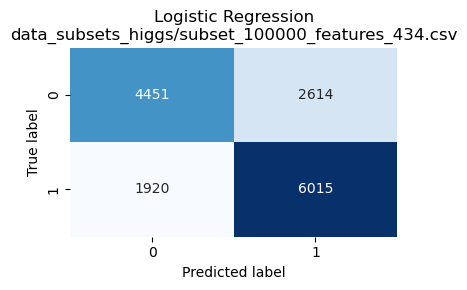

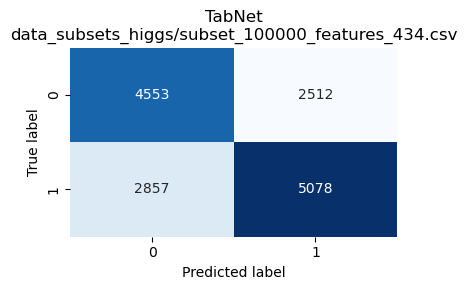

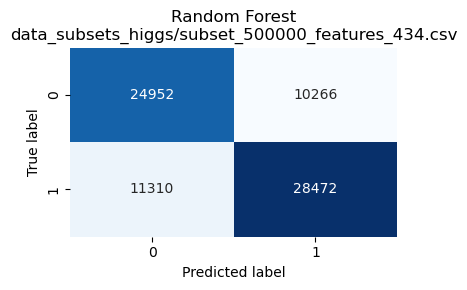

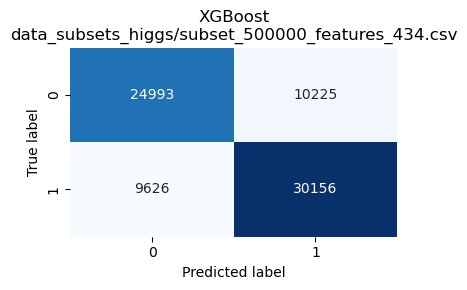

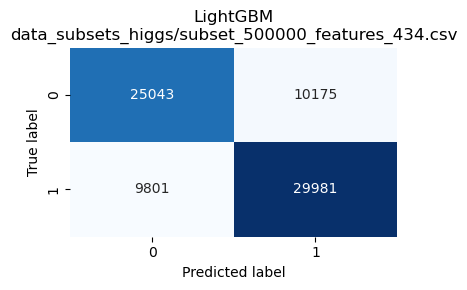

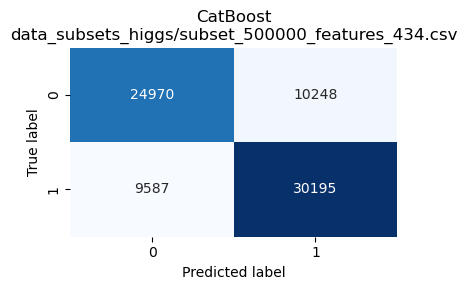

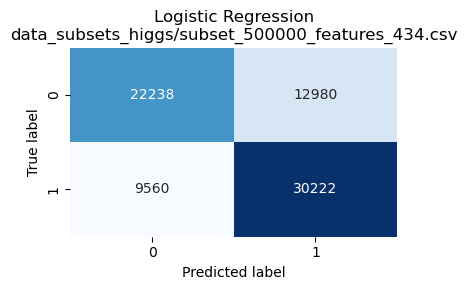

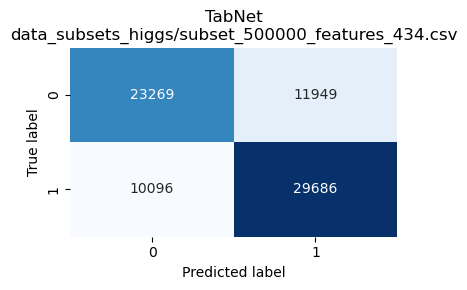

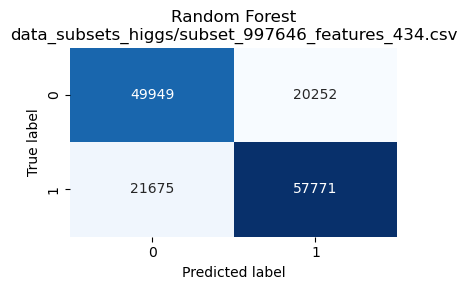

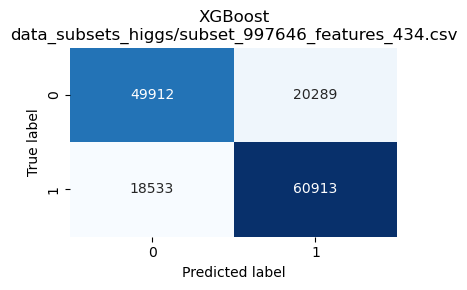

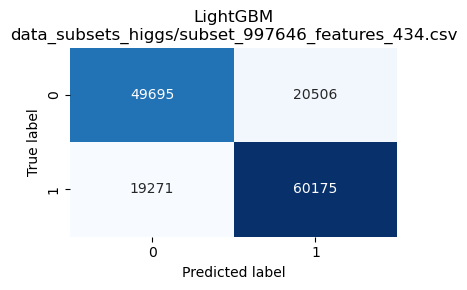

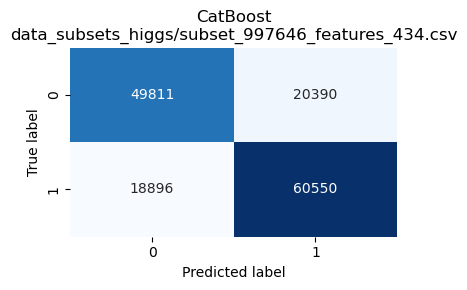

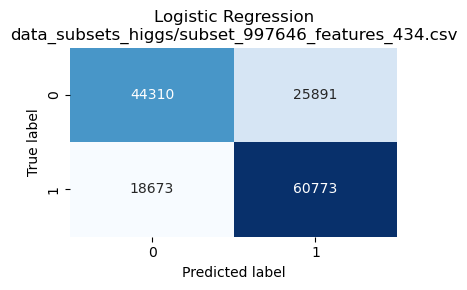

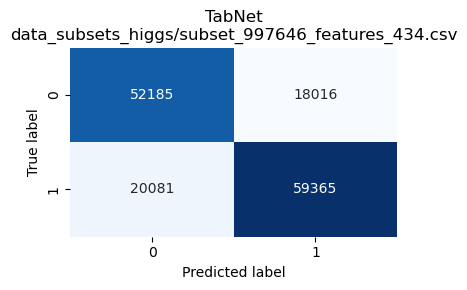

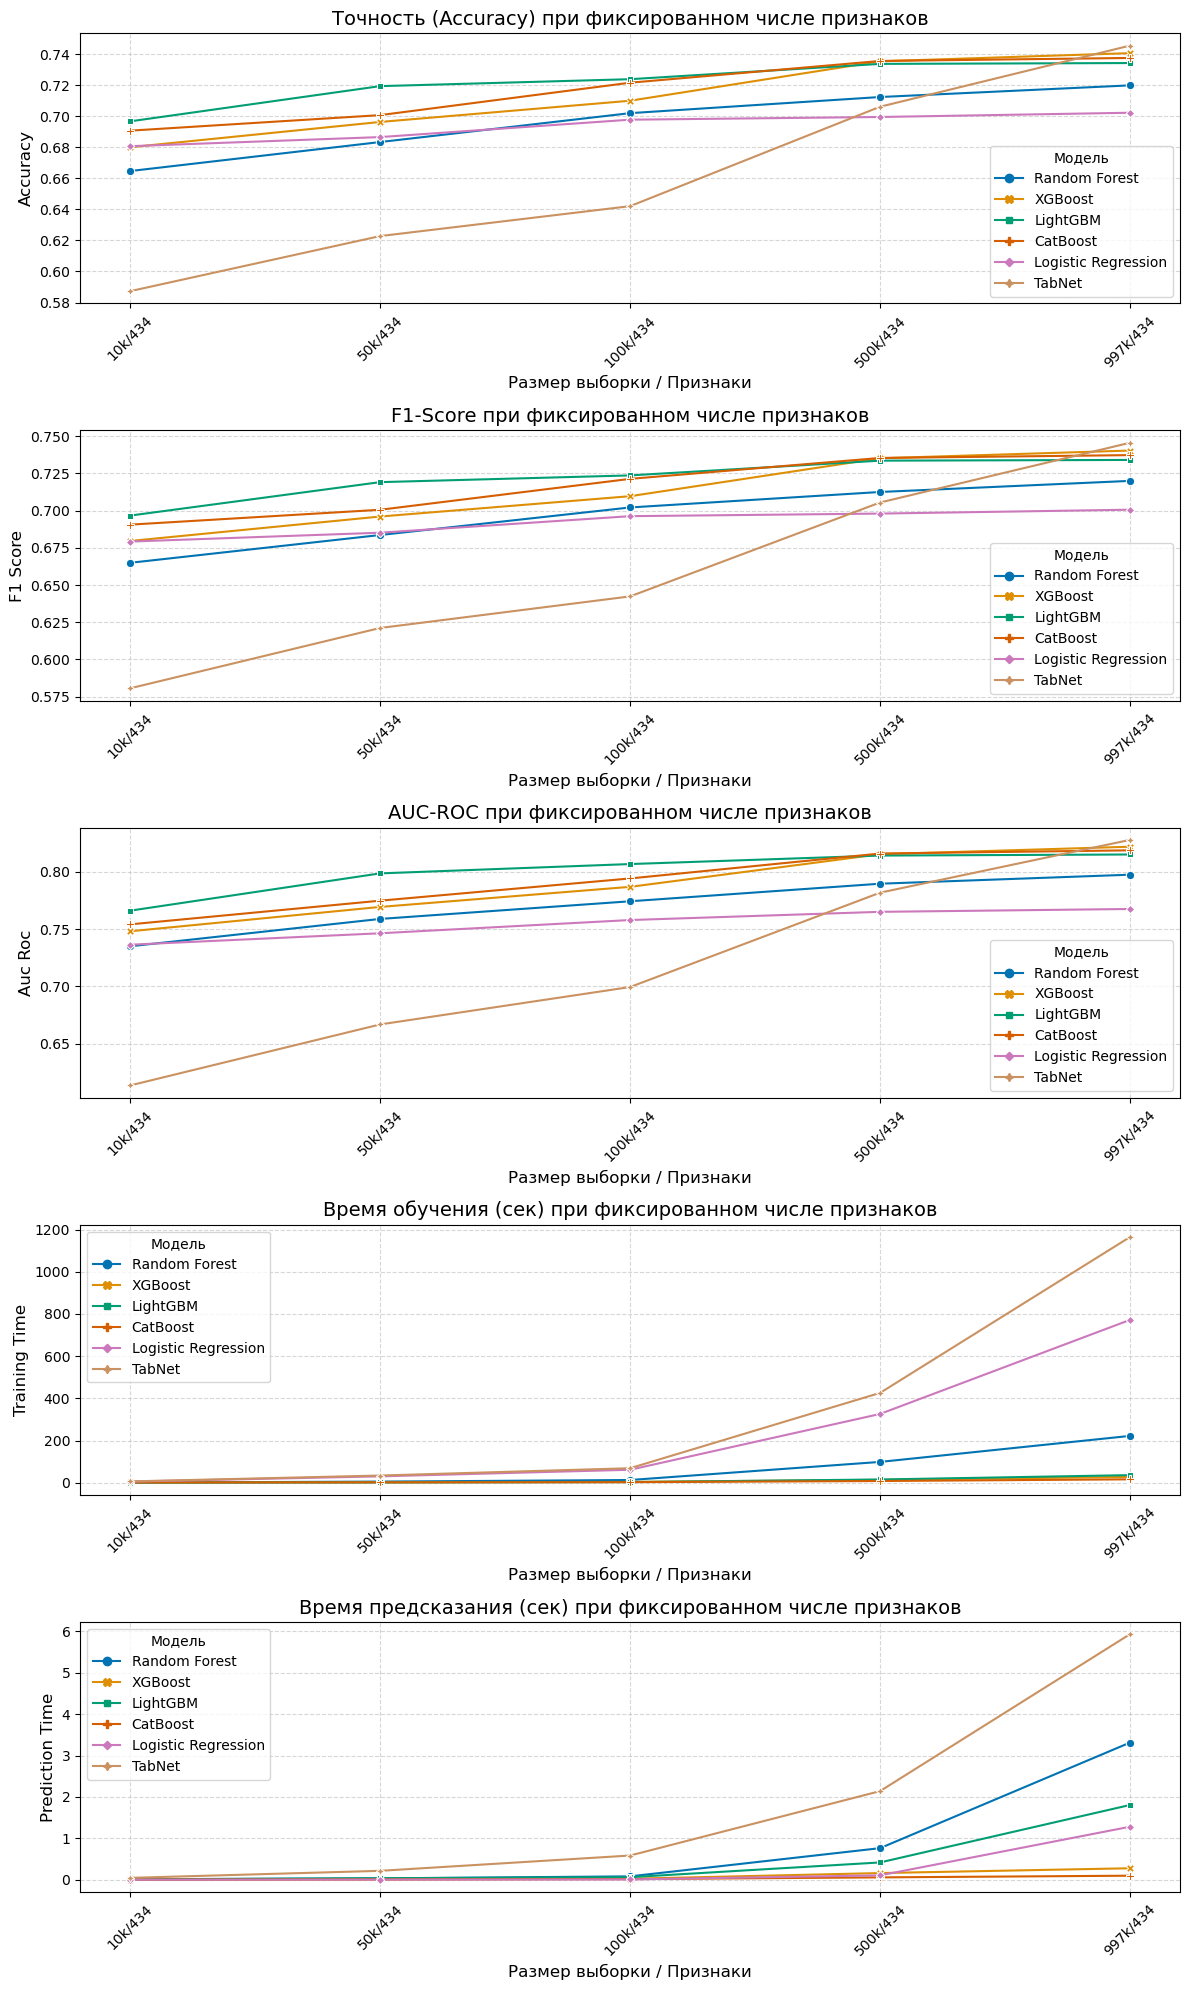

In [2]:
%matplotlib inline

results_list = []
for key, value in all_results.items():
    model_name, file = key.split("_", 1)
    results_list.append({
        "model": model_name,
        "file": file,
        "accuracy": value["accuracy"],
        "f1_score": value["f1_score"],
        "auc_roc": value["auc_roc"],
        "training_time": value.get("training_time", None),  
        "prediction_time": value.get("prediction_time", None),
        "confusion_matrix": value.get("confusion_matrix", None) 
    })

results_df = pd.DataFrame(results_list)

def rename_file_column(df):
    def transform_filename(filename):
        base_name = os.path.basename(filename)
        parts = base_name.replace(".csv", "").split("_")
        size = int(parts[1]) // 1000 
        features = parts[3]           
        return f"{size}k/{features}"  

    df["file"] = df["file"].apply(transform_filename)
    return df

def plot_confusion_matrix(cm, model_name, file_name):
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False
    )
    plt.title(f"{model_name}\n{file_name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

results_df = rename_file_column(results_df)

print("=" * 80)
print("CONFUSION MATRICES: files_1")
print("=" * 80)

for key, value in all_results.items():
    cm = value.get("confusion_matrix", None)
    if cm is None:
        continue

    model_name, file_name = key.split("_", 1)
    plot_confusion_matrix(
        cm=cm,
        model_name=model_name,
        file_name=file_name
    )

palette = sns.color_palette("colorblind")

plot_titles = [
    "Точность (Accuracy)",
    "F1-Score",
    "AUC-ROC",
    "Время обучения (сек)",
    "Время предсказания (сек)"
]
metrics = ["accuracy", "f1_score", "auc_roc", "training_time", "prediction_time"]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20))

for idx, ax in enumerate(axes):
    metric = metrics[idx]
    
    if metric not in results_df.columns:
        continue
    
    sns.lineplot(
        data=results_df,
        x='file',
        y=metric,
        hue='model',
        style='model',
        markers=True,
        dashes=False,
        palette=palette,
        ax=ax
    )
    
    ax.set_title(f"{plot_titles[idx]} при фиксированном числе признаков", fontsize=14)
    ax.set_xlabel('Размер выборки / Признаки', fontsize=12)
    ax.set_ylabel(metric.replace("_", " ").title(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title='Модель', loc='best')

plt.tight_layout()
plt.show()

### Табличное сравнение моделей (files_1)

Формируем итоговые таблицы сравнения моделей по каждой метрике.

In [3]:
from IPython.display import display, Markdown
from tabulate import tabulate

metrics_for_tables = ["accuracy", "f1_score", "auc_roc", "training_time", "prediction_time"]

print("Итоговые таблицы по метрикам для каждого файла")

for metric in metrics_for_tables:
    print(f"Топ моделей по {metric.replace('_', ' ').title()}")
    
    metric_table = results_df[["model", "file", metric]].copy()
    metric_table = metric_table.dropna(subset=[metric])
    metric_table = metric_table.sort_values(by=metric, ascending=False)
    
    table_str = tabulate(metric_table, headers='keys', tablefmt='github', showindex=False, floatfmt=".4f")
    
    print(table_str)
    print("\n")

Итоговые таблицы по метрикам для каждого файла
Топ моделей по Accuracy
| model               | file     |   accuracy |
|---------------------|----------|------------|
| TabNet              | 997k/434 |     0.7454 |
| XGBoost             | 997k/434 |     0.7406 |
| CatBoost            | 997k/434 |     0.7375 |
| CatBoost            | 500k/434 |     0.7355 |
| XGBoost             | 500k/434 |     0.7353 |
| LightGBM            | 997k/434 |     0.7342 |
| LightGBM            | 500k/434 |     0.7337 |
| LightGBM            | 100k/434 |     0.7238 |
| CatBoost            | 100k/434 |     0.7215 |
| Random Forest       | 997k/434 |     0.7198 |
| LightGBM            | 50k/434  |     0.7193 |
| Random Forest       | 500k/434 |     0.7123 |
| XGBoost             | 100k/434 |     0.7099 |
| TabNet              | 500k/434 |     0.7061 |
| Logistic Regression | 997k/434 |     0.7022 |
| Random Forest       | 100k/434 |     0.7019 |
| CatBoost            | 50k/434  |     0.7007 |
| Logistic Regres

### Эксперименты с переменным числом признаков

Проводим обучение и оценку моделей на подвыборках с переменным числом признаков

In [4]:
all_results_var_features = {}

for file in files_2:
    print(f"Processing file: {file}")
    
    data_2 = pd.read_csv(file)
    data_2.columns = data_2.columns.str.replace(" ", "_")
    
    X_2 = data_2.drop(columns=["target"])
    y_2 = data_2["target"]
    
    X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(
        X_2, y_2, test_size=0.3, random_state=123, stratify=y_2
    )
    X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(
        X_temp_2, y_temp_2, test_size=0.5, random_state=123, stratify=y_temp_2
    )

    X_train_np_2 = X_train_2.values
    X_val_np_2 = X_val_2.values
    X_test_np_2 = X_test_2.values
    y_train_np_2 = y_train_2
    y_val_np_2 = y_val_2
    y_test_np_2 = y_test_2
    
    # Обучаем классические модели
    classical_results_2 = train_and_evaluate_classical_models(
    X_train_np_2, y_train_np_2, X_test_np_2, y_test_np_2
    )
    
    for model_name, result in classical_results_2.items():
        all_results_var_features[f"{model_name}_{file}"] = result
    
    # Обучаем TabNet
    tabnet_model_2 = TabNetClassifier(
        n_d=16, n_a=16, n_steps=3, gamma=1.7, lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler_params={"mode": "max", "patience": 5, "min_lr": 1e-5, "factor": 0.5}
    )

    start_time = time.time()
    
    tabnet_model_2.fit(
        X_train=X_train_np_2, y_train=y_train_np_2,
        eval_set=[(X_val_np_2, y_val_np_2)],
        eval_name=["test"],
        eval_metric=["auc"],
        max_epochs=20,
        patience=10,
        batch_size=2048,
        virtual_batch_size=256
    )
    training_time_2 = time.time() - start_time

    # Предсказание
    start_time = time.time()
    y_pred_proba_2 = tabnet_model_2.predict_proba(X_test_np_2)
    y_pred_proba_pos_2 = y_pred_proba_2[:, 1]
    y_pred_2 = np.argmax(y_pred_proba_2, axis=1)
    cm_tabnet_2 = confusion_matrix(y_test_np_2, y_pred_2)
    prediction_time_2 = time.time() - start_time

    # Метрики
    accuracy_2 = accuracy_score(y_test_np_2, y_pred_2)
    f1_2 = f1_score(y_test_np_2, y_pred_2, average='weighted')
    auc_roc_2 = roc_auc_score(y_test_np_2, y_pred_proba_pos_2)

    all_results_var_features[f"TabNet_{file}"] = {
        "accuracy": accuracy_2,
        "f1_score": f1_2,
        "auc_roc": auc_roc_2,
        "training_time": training_time_2,
        "prediction_time": prediction_time_2,
        "confusion_matrix": cm_tabnet_2
    }
    
    print(f"TabNet Results:")
    print(f"Accuracy: {accuracy_2:.4f}")
    print(f"F1-Score: {f1_2:.4f}")
    print(f"AUC-ROC: {auc_roc_2:.4f}")
    print(f"Prediction Time: {prediction_time_2:.4f} seconds")
    print("Confusion Matrix (TabNet):")
    print(cm_tabnet_2)
    print("-" * 50)

Processing file: data_subsets_higgs/subset_10000_features_10.csv
Training Random Forest...
Random Forest Results:
Accuracy: 0.5853
F1-Score: 0.5853
AUC-ROC: 0.6113
Training Time: 0.17 seconds
Prediction Time: 0.0107 seconds
Confusion Matrix:
[[395 312]
 [310 483]]
--------------------------------------------------
Training XGBoost...
XGBoost Results:
Accuracy: 0.5847
F1-Score: 0.5833
AUC-ROC: 0.6154
Training Time: 0.08 seconds
Prediction Time: 0.0022 seconds
Confusion Matrix:
[[369 338]
 [285 508]]
--------------------------------------------------
Training LightGBM...
[LightGBM] [Info] Number of positive: 3703, number of negative: 3297
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2299
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529000 -> initsco

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.5793
F1-Score: 0.5778
AUC-ROC: 0.6059
Training Time: 0.22 seconds
Prediction Time: 0.0081 seconds
Confusion Matrix:
[[363 344]
 [287 506]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.6067
F1-Score: 0.6035
AUC-ROC: 0.6389
Training Time: 0.17 seconds
Prediction Time: 0.0035 seconds
Confusion Matrix:
[[363 344]
 [246 547]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.5600
F1-Score: 0.5511
AUC-ROC: 0.5772
Training Time: 0.02 seconds
Prediction Time: 0.0020 seconds
Confusion Matrix:
[[291 416]
 [244 549]]
--------------------------------------------------
epoch 0  | loss: 1.01602 | test_auc: 0.48548 |  0:00:00s
epoch 1  | loss: 0.76433 | test_auc: 0.50025 |  0:00:00s
epoch 2  | loss: 0.72033 | test_auc: 0.52967 |  0:00:00s
epoch 3  | loss: 0.7012  | test_auc: 0.56043 |  0:00:00s
epoch 4  | loss: 0.69153 | test_auc: 0.5794  |  

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7073
F1-Score: 0.7070
AUC-ROC: 0.7802
Training Time: 0.36 seconds
Prediction Time: 0.0089 seconds
Confusion Matrix:
[[475 232]
 [207 586]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.6907
F1-Score: 0.6904
AUC-ROC: 0.7623
Training Time: 0.30 seconds
Prediction Time: 0.0030 seconds
Confusion Matrix:
[[467 240]
 [224 569]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6400
F1-Score: 0.6381
AUC-ROC: 0.6670
Training Time: 0.03 seconds
Prediction Time: 0.0022 seconds
Confusion Matrix:
[[400 307]
 [233 560]]
--------------------------------------------------
epoch 0  | loss: 1.22111 | test_auc: 0.51817 |  0:00:00s
epoch 1  | loss: 0.85833 | test_auc: 0.54349 |  0:00:00s
epoch 2  | loss: 0.77489 | test_auc: 0.51702 |  0:00:00s
epoch 3  | loss: 0.73664 | test_auc: 0.50594 |  0:00:00s
epoch 4  | loss: 0.71249 | test_auc: 0.52093 |  

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7120
F1-Score: 0.7115
AUC-ROC: 0.7769
Training Time: 0.42 seconds
Prediction Time: 0.0066 seconds
Confusion Matrix:
[[474 233]
 [199 594]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.6947
F1-Score: 0.6944
AUC-ROC: 0.7609
Training Time: 0.52 seconds
Prediction Time: 0.0037 seconds
Confusion Matrix:
[[468 239]
 [219 574]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6420
F1-Score: 0.6403
AUC-ROC: 0.6703
Training Time: 0.10 seconds
Prediction Time: 0.0014 seconds
Confusion Matrix:
[[404 303]
 [234 559]]
--------------------------------------------------
epoch 0  | loss: 1.0008  | test_auc: 0.49886 |  0:00:00s
epoch 1  | loss: 0.81218 | test_auc: 0.51265 |  0:00:00s
epoch 2  | loss: 0.74471 | test_auc: 0.55329 |  0:00:00s
epoch 3  | loss: 0.72392 | test_auc: 0.54119 |  0:00:00s
epoch 4  | loss: 0.70605 | test_auc: 0.53079 |  

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7053
F1-Score: 0.7051
AUC-ROC: 0.7687
Training Time: 0.83 seconds
Prediction Time: 0.0085 seconds
Confusion Matrix:
[[477 230]
 [212 581]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.6933
F1-Score: 0.6932
AUC-ROC: 0.7658
Training Time: 0.84 seconds
Prediction Time: 0.0042 seconds
Confusion Matrix:
[[471 236]
 [224 569]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6507
F1-Score: 0.6487
AUC-ROC: 0.6885
Training Time: 1.11 seconds
Prediction Time: 0.0012 seconds
Confusion Matrix:
[[407 300]
 [224 569]]
--------------------------------------------------
epoch 0  | loss: 1.06217 | test_auc: 0.52782 |  0:00:00s
epoch 1  | loss: 0.86408 | test_auc: 0.53283 |  0:00:00s
epoch 2  | loss: 0.78502 | test_auc: 0.53378 |  0:00:00s
epoch 3  | loss: 0.74521 | test_auc: 0.51527 |  0:00:01s
epoch 4  | loss: 0.71749 | test_auc: 0.53189 |  

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.6967
F1-Score: 0.6967
AUC-ROC: 0.7660
Training Time: 1.55 seconds
Prediction Time: 0.0127 seconds
Confusion Matrix:
[[479 228]
 [227 566]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.6907
F1-Score: 0.6906
AUC-ROC: 0.7541
Training Time: 1.61 seconds
Prediction Time: 0.0068 seconds
Confusion Matrix:
[[471 236]
 [228 565]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6807
F1-Score: 0.6792
AUC-ROC: 0.7363
Training Time: 5.75 seconds
Prediction Time: 0.0030 seconds
Confusion Matrix:
[[434 273]
 [206 587]]
--------------------------------------------------
epoch 0  | loss: 0.96158 | test_auc: 0.46686 |  0:00:00s
epoch 1  | loss: 0.78125 | test_auc: 0.49199 |  0:00:00s
epoch 2  | loss: 0.73898 | test_auc: 0.51246 |  0:00:01s
epoch 3  | loss: 0.7109  | test_auc: 0.5185  |  0:00:01s
epoch 4  | loss: 0.70079 | test_auc: 0.52368 |  

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.5985
F1-Score: 0.5967
AUC-ROC: 0.6446
Training Time: 0.31 seconds
Prediction Time: 0.0196 seconds
Confusion Matrix:
[[1859 1672]
 [1339 2630]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.6080
F1-Score: 0.6062
AUC-ROC: 0.6516
Training Time: 0.22 seconds
Prediction Time: 0.0060 seconds
Confusion Matrix:
[[1895 1636]
 [1304 2665]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.5607
F1-Score: 0.5493
AUC-ROC: 0.5736
Training Time: 0.06 seconds
Prediction Time: 0.0033 seconds
Confusion Matrix:
[[1391 2140]
 [1155 2814]]
--------------------------------------------------
epoch 0  | loss: 0.76531 | test_auc: 0.54817 |  0:00:00s
epoch 1  | loss: 0.68486 | test_auc: 0.58012 |  0:00:01s
epoch 2  | loss: 0.68105 | test_auc: 0.59276 |  0:00:01s
epoch 3  | loss: 0.67767 | test_auc: 0.6033  |  0:00:01s
epoch 4  | loss: 0.67567 | test_auc:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7181
F1-Score: 0.7180
AUC-ROC: 0.7986
Training Time: 0.58 seconds
Prediction Time: 0.0230 seconds
Confusion Matrix:
[[2456 1075]
 [1039 2930]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7104
F1-Score: 0.7102
AUC-ROC: 0.7854
Training Time: 0.56 seconds
Prediction Time: 0.0065 seconds
Confusion Matrix:
[[2414 1117]
 [1055 2914]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6308
F1-Score: 0.6280
AUC-ROC: 0.6731
Training Time: 0.13 seconds
Prediction Time: 0.0028 seconds
Confusion Matrix:
[[1912 1619]
 [1150 2819]]
--------------------------------------------------
epoch 0  | loss: 0.85007 | test_auc: 0.56465 |  0:00:00s
epoch 1  | loss: 0.6914  | test_auc: 0.58112 |  0:00:01s
epoch 2  | loss: 0.67581 | test_auc: 0.62025 |  0:00:01s
epoch 3  | loss: 0.66411 | test_auc: 0.64226 |  0:00:01s
epoch 4  | loss: 0.65486 | test_auc:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7195
F1-Score: 0.7193
AUC-ROC: 0.7951
Training Time: 0.95 seconds
Prediction Time: 0.0282 seconds
Confusion Matrix:
[[2445 1086]
 [1018 2951]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7109
F1-Score: 0.7105
AUC-ROC: 0.7846
Training Time: 0.80 seconds
Prediction Time: 0.0090 seconds
Confusion Matrix:
[[2377 1154]
 [1014 2955]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6317
F1-Score: 0.6291
AUC-ROC: 0.6738
Training Time: 0.57 seconds
Prediction Time: 0.0057 seconds
Confusion Matrix:
[[1928 1603]
 [1159 2810]]
--------------------------------------------------
epoch 0  | loss: 0.81354 | test_auc: 0.50412 |  0:00:00s
epoch 1  | loss: 0.70093 | test_auc: 0.53479 |  0:00:01s
epoch 2  | loss: 0.68762 | test_auc: 0.55008 |  0:00:01s
epoch 3  | loss: 0.68264 | test_auc: 0.58025 |  0:00:02s
epoch 4  | loss: 0.67688 | test_auc:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 18523, number of negative: 16477
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49996
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529229 -> initscore=0.117048
[LightGBM] [Info] Start training from score 0.117048


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7160
F1-Score: 0.7160
AUC-ROC: 0.7957
Training Time: 1.65 seconds
Prediction Time: 0.0300 seconds
Confusion Matrix:
[[2463 1068]
 [1062 2907]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7093
F1-Score: 0.7090
AUC-ROC: 0.7829
Training Time: 1.27 seconds
Prediction Time: 0.0203 seconds
Confusion Matrix:
[[2389 1142]
 [1038 2931]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6507
F1-Score: 0.6488
AUC-ROC: 0.6974
Training Time: 3.44 seconds
Prediction Time: 0.0162 seconds
Confusion Matrix:
[[2038 1493]
 [1127 2842]]
--------------------------------------------------
epoch 0  | loss: 0.84411 | test_auc: 0.52839 |  0:00:00s
epoch 1  | loss: 0.7045  | test_auc: 0.54484 |  0:00:01s
epoch 2  | loss: 0.68872 | test_auc: 0.56559 |  0:00:02s
epoch 3  | loss: 0.68086 | test_auc: 0.60411 |  0:00:03s
epoch 4  | loss: 0.67365 | test_auc:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 18523, number of negative: 16477
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107192
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 434
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529229 -> initscore=0.117048
[LightGBM] [Info] Start training from score 0.117048


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7193
F1-Score: 0.7191
AUC-ROC: 0.7985
Training Time: 3.25 seconds
Prediction Time: 0.0345 seconds
Confusion Matrix:
[[2438 1093]
 [1012 2957]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7007
F1-Score: 0.7006
AUC-ROC: 0.7747
Training Time: 2.33 seconds
Prediction Time: 0.0158 seconds
Confusion Matrix:
[[2388 1143]
 [1102 2867]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6865
F1-Score: 0.6851
AUC-ROC: 0.7463
Training Time: 30.46 seconds
Prediction Time: 0.0068 seconds
Confusion Matrix:
[[2194 1337]
 [1014 2955]]
--------------------------------------------------
epoch 0  | loss: 0.7829  | test_auc: 0.51135 |  0:00:02s
epoch 1  | loss: 0.6951  | test_auc: 0.52951 |  0:00:04s
epoch 2  | loss: 0.68879 | test_auc: 0.57209 |  0:00:06s
epoch 3  | loss: 0.6823  | test_auc: 0.59396 |  0:00:07s
epoch 4  | loss: 0.67295 | test_auc

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.6106
F1-Score: 0.6092
AUC-ROC: 0.6548
Training Time: 0.28 seconds
Prediction Time: 0.0307 seconds
Confusion Matrix:
[[3868 3197]
 [2644 5291]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.6063
F1-Score: 0.6042
AUC-ROC: 0.6514
Training Time: 0.31 seconds
Prediction Time: 0.0084 seconds
Confusion Matrix:
[[3753 3312]
 [2594 5341]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.5548
F1-Score: 0.5402
AUC-ROC: 0.5709
Training Time: 0.12 seconds
Prediction Time: 0.0054 seconds
Confusion Matrix:
[[2599 4466]
 [2212 5723]]
--------------------------------------------------
epoch 0  | loss: 0.72476 | test_auc: 0.58415 |  0:00:01s
epoch 1  | loss: 0.67968 | test_auc: 0.59614 |  0:00:01s
epoch 2  | loss: 0.67569 | test_auc: 0.59994 |  0:00:02s
epoch 3  | loss: 0.67378 | test_auc: 0.60919 |  0:00:03s
epoch 4  | loss: 0.66916 | test_auc:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7229
F1-Score: 0.7228
AUC-ROC: 0.8057
Training Time: 0.92 seconds
Prediction Time: 0.0467 seconds
Confusion Matrix:
[[4944 2121]
 [2036 5899]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7187
F1-Score: 0.7184
AUC-ROC: 0.7960
Training Time: 0.80 seconds
Prediction Time: 0.0146 seconds
Confusion Matrix:
[[4870 2195]
 [2025 5910]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6429
F1-Score: 0.6399
AUC-ROC: 0.6776
Training Time: 0.29 seconds
Prediction Time: 0.0052 seconds
Confusion Matrix:
[[3887 3178]
 [2178 5757]]
--------------------------------------------------
epoch 0  | loss: 0.77186 | test_auc: 0.6257  |  0:00:01s
epoch 1  | loss: 0.65369 | test_auc: 0.66511 |  0:00:02s
epoch 2  | loss: 0.63965 | test_auc: 0.68583 |  0:00:02s
epoch 3  | loss: 0.62774 | test_auc: 0.70055 |  0:00:04s
epoch 4  | loss: 0.62393 | test_auc:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 37029, number of negative: 32971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24496
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528986 -> initscore=0.116073
[LightGBM] [Info] Start training from score 0.116073


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7279
F1-Score: 0.7278
AUC-ROC: 0.8088
Training Time: 1.50 seconds
Prediction Time: 0.0495 seconds
Confusion Matrix:
[[4976 2089]
 [1993 5942]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7199
F1-Score: 0.7197
AUC-ROC: 0.7955
Training Time: 1.07 seconds
Prediction Time: 0.0093 seconds
Confusion Matrix:
[[4875 2190]
 [2011 5924]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6410
F1-Score: 0.6380
AUC-ROC: 0.6800
Training Time: 0.51 seconds
Prediction Time: 0.0055 seconds
Confusion Matrix:
[[3872 3193]
 [2192 5743]]
--------------------------------------------------
epoch 0  | loss: 0.74922 | test_auc: 0.56957 |  0:00:01s
epoch 1  | loss: 0.67425 | test_auc: 0.63688 |  0:00:02s
epoch 2  | loss: 0.65743 | test_auc: 0.66802 |  0:00:03s
epoch 3  | loss: 0.64996 | test_auc: 0.67196 |  0:00:04s
epoch 4  | loss: 0.64314 | test_auc:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 37029, number of negative: 32971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49996
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528986 -> initscore=0.116073
[LightGBM] [Info] Start training from score 0.116073


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7235
F1-Score: 0.7234
AUC-ROC: 0.8064
Training Time: 2.59 seconds
Prediction Time: 0.0545 seconds
Confusion Matrix:
[[4953 2112]
 [2035 5900]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7143
F1-Score: 0.7139
AUC-ROC: 0.7915
Training Time: 1.76 seconds
Prediction Time: 0.0148 seconds
Confusion Matrix:
[[4795 2270]
 [2016 5919]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6622
F1-Score: 0.6601
AUC-ROC: 0.7060
Training Time: 2.82 seconds
Prediction Time: 0.0066 seconds
Confusion Matrix:
[[4122 2943]
 [2124 5811]]
--------------------------------------------------
epoch 0  | loss: 0.77265 | test_auc: 0.53049 |  0:00:01s
epoch 1  | loss: 0.68948 | test_auc: 0.55996 |  0:00:03s
epoch 2  | loss: 0.68206 | test_auc: 0.60173 |  0:00:05s
epoch 3  | loss: 0.67324 | test_auc: 0.62404 |  0:00:07s
epoch 4  | loss: 0.66534 | test_auc:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 37029, number of negative: 32971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107192
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 434
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528986 -> initscore=0.116073
[LightGBM] [Info] Start training from score 0.116073


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7238
F1-Score: 0.7236
AUC-ROC: 0.8067
Training Time: 4.18 seconds
Prediction Time: 0.0656 seconds
Confusion Matrix:
[[4930 2135]
 [2008 5927]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7215
F1-Score: 0.7213
AUC-ROC: 0.7941
Training Time: 3.06 seconds
Prediction Time: 0.0277 seconds
Confusion Matrix:
[[4894 2171]
 [2006 5929]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6977
F1-Score: 0.6963
AUC-ROC: 0.7578
Training Time: 61.96 seconds
Prediction Time: 0.0134 seconds
Confusion Matrix:
[[4451 2614]
 [1920 6015]]
--------------------------------------------------
epoch 0  | loss: 0.73896 | test_auc: 0.56356 |  0:00:03s
epoch 1  | loss: 0.67635 | test_auc: 0.62108 |  0:00:06s
epoch 2  | loss: 0.66299 | test_auc: 0.64755 |  0:00:10s
epoch 3  | loss: 0.66033 | test_auc: 0.6462  |  0:00:14s
epoch 4  | loss: 0.65768 | test_auc

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.6225
F1-Score: 0.6212
AUC-ROC: 0.6675
Training Time: 1.10 seconds
Prediction Time: 0.1445 seconds
Confusion Matrix:
[[19716 15502]
 [12812 26970]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.6267
F1-Score: 0.6247
AUC-ROC: 0.6748
Training Time: 0.95 seconds
Prediction Time: 0.0312 seconds
Confusion Matrix:
[[19392 15826]
 [12168 27614]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.5558
F1-Score: 0.5400
AUC-ROC: 0.5716
Training Time: 0.99 seconds
Prediction Time: 0.0263 seconds
Confusion Matrix:
[[12707 22511]
 [10805 28977]]
--------------------------------------------------
epoch 0  | loss: 0.69012 | test_auc: 0.60844 |  0:00:03s
epoch 1  | loss: 0.66829 | test_auc: 0.62559 |  0:00:07s
epoch 2  | loss: 0.66392 | test_auc: 0.63658 |  0:00:11s
epoch 3  | loss: 0.65976 | test_auc: 0.63796 |  0:00:15s
epoch 4  | loss: 0.65844

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 185653, number of negative: 164347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530437 -> initscore=0.121899
[LightGBM] [Info] Start training from score 0.121899


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7296
F1-Score: 0.7296
AUC-ROC: 0.8104
Training Time: 3.14 seconds
Prediction Time: 0.2132 seconds
Confusion Matrix:
[[25079 10139]
 [10139 29643]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7332
F1-Score: 0.7331
AUC-ROC: 0.8127
Training Time: 2.30 seconds
Prediction Time: 0.0442 seconds
Confusion Matrix:
[[24948 10270]
 [ 9739 30043]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6406
F1-Score: 0.6370
AUC-ROC: 0.6794
Training Time: 1.64 seconds
Prediction Time: 0.0282 seconds
Confusion Matrix:
[[19000 16218]
 [10736 29046]]
--------------------------------------------------
epoch 0  | loss: 0.67514 | test_auc: 0.71096 |  0:00:04s
epoch 1  | loss: 0.60931 | test_auc: 0.74076 |  0:00:08s
epoch 2  | loss: 0.59098 | test_auc: 0.75801 |  0:00:13s
epoch 3  | loss: 0.58001 | test_auc: 0.76929 |  0:00:17s
epoch 4  | loss: 0.57041

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 185653, number of negative: 164347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24496
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530437 -> initscore=0.121899
[LightGBM] [Info] Start training from score 0.121899


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7313
F1-Score: 0.7312
AUC-ROC: 0.8127
Training Time: 4.12 seconds
Prediction Time: 0.2177 seconds
Confusion Matrix:
[[24966 10252]
 [ 9904 29878]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7341
F1-Score: 0.7339
AUC-ROC: 0.8154
Training Time: 3.14 seconds
Prediction Time: 0.0429 seconds
Confusion Matrix:
[[24908 10310]
 [ 9632 30150]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6428
F1-Score: 0.6395
AUC-ROC: 0.6826
Training Time: 2.76 seconds
Prediction Time: 0.0308 seconds
Confusion Matrix:
[[19171 16047]
 [10740 29042]]
--------------------------------------------------
epoch 0  | loss: 0.67418 | test_auc: 0.67905 |  0:00:05s
epoch 1  | loss: 0.64107 | test_auc: 0.68774 |  0:00:11s
epoch 2  | loss: 0.63522 | test_auc: 0.69518 |  0:00:17s
epoch 3  | loss: 0.62987 | test_auc: 0.69937 |  0:00:22s
epoch 4  | loss: 0.62868

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 185653, number of negative: 164347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49996
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530437 -> initscore=0.121899
[LightGBM] [Info] Start training from score 0.121899


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7323
F1-Score: 0.7322
AUC-ROC: 0.8128
Training Time: 9.53 seconds
Prediction Time: 0.3037 seconds
Confusion Matrix:
[[25074 10144]
 [ 9937 29845]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7345
F1-Score: 0.7343
AUC-ROC: 0.8143
Training Time: 5.17 seconds
Prediction Time: 0.0653 seconds
Confusion Matrix:
[[24876 10342]
 [ 9571 30211]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6650
F1-Score: 0.6628
AUC-ROC: 0.7123
Training Time: 7.14 seconds
Prediction Time: 0.0864 seconds
Confusion Matrix:
[[20549 14669]
 [10454 29328]]
--------------------------------------------------
epoch 0  | loss: 0.70076 | test_auc: 0.62157 |  0:00:08s
epoch 1  | loss: 0.66245 | test_auc: 0.65538 |  0:00:16s
epoch 2  | loss: 0.65308 | test_auc: 0.66522 |  0:00:26s
epoch 3  | loss: 0.64748 | test_auc: 0.67301 |  0:00:34s
epoch 4  | loss: 0.64223

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 185653, number of negative: 164347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107192
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 434
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530437 -> initscore=0.121899
[LightGBM] [Info] Start training from score 0.121899


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7337
F1-Score: 0.7336
AUC-ROC: 0.8141
Training Time: 16.03 seconds
Prediction Time: 0.3766 seconds
Confusion Matrix:
[[25043 10175]
 [ 9801 29981]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7355
F1-Score: 0.7354
AUC-ROC: 0.8158
Training Time: 8.64 seconds
Prediction Time: 0.0940 seconds
Confusion Matrix:
[[24970 10248]
 [ 9587 30195]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6995
F1-Score: 0.6980
AUC-ROC: 0.7650
Training Time: 328.04 seconds
Prediction Time: 0.1249 seconds
Confusion Matrix:
[[22238 12980]
 [ 9560 30222]]
--------------------------------------------------
epoch 0  | loss: 0.68194 | test_auc: 0.65204 |  0:00:17s
epoch 1  | loss: 0.6541  | test_auc: 0.67005 |  0:00:34s
epoch 2  | loss: 0.64685 | test_auc: 0.67614 |  0:00:50s
epoch 3  | loss: 0.64317 | test_auc: 0.68225 |  0:01:07s
epoch 4  | loss: 0.64

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.6209
F1-Score: 0.6192
AUC-ROC: 0.6685
Training Time: 1.91 seconds
Prediction Time: 0.2974 seconds
Confusion Matrix:
[[38668 31533]
 [25200 54246]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.6277
F1-Score: 0.6252
AUC-ROC: 0.6785
Training Time: 1.90 seconds
Prediction Time: 0.0779 seconds
Confusion Matrix:
[[38163 32038]
 [23677 55769]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.5577
F1-Score: 0.5413
AUC-ROC: 0.5742
Training Time: 2.41 seconds
Prediction Time: 0.0551 seconds
Confusion Matrix:
[[25178 45023]
 [21169 58277]]
--------------------------------------------------
epoch 0  | loss: 0.67879 | test_auc: 0.62395 |  0:00:07s
epoch 1  | loss: 0.66166 | test_auc: 0.64381 |  0:00:14s
epoch 2  | loss: 0.6538  | test_auc: 0.66249 |  0:00:21s
epoch 3  | loss: 0.64807 | test_auc: 0.6688  |  0:00:28s
epoch 4  | loss: 0.64611

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 370750, number of negative: 327602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11746
[LightGBM] [Info] Number of data points in the train set: 698352, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530893 -> initscore=0.123729
[LightGBM] [Info] Start training from score 0.123729


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7319
F1-Score: 0.7318
AUC-ROC: 0.8118
Training Time: 5.56 seconds
Prediction Time: 0.4355 seconds
Confusion Matrix:
[[49858 20343]
 [19781 59665]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7360
F1-Score: 0.7358
AUC-ROC: 0.8163
Training Time: 4.57 seconds
Prediction Time: 0.0930 seconds
Confusion Matrix:
[[49685 20516]
 [18995 60451]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6414
F1-Score: 0.6377
AUC-ROC: 0.6802
Training Time: 4.23 seconds
Prediction Time: 0.0575 seconds
Confusion Matrix:
[[37861 32340]
 [21330 58116]]
--------------------------------------------------
epoch 0  | loss: 0.64377 | test_auc: 0.72713 |  0:00:08s
epoch 1  | loss: 0.60391 | test_auc: 0.74012 |  0:00:17s
epoch 2  | loss: 0.59598 | test_auc: 0.74472 |  0:00:25s
epoch 3  | loss: 0.58523 | test_auc: 0.76783 |  0:00:33s
epoch 4  | loss: 0.56642

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 370750, number of negative: 327602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24496
[LightGBM] [Info] Number of data points in the train set: 698352, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530893 -> initscore=0.123729
[LightGBM] [Info] Start training from score 0.123729


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7346
F1-Score: 0.7344
AUC-ROC: 0.8147
Training Time: 9.14 seconds
Prediction Time: 0.4392 seconds
Confusion Matrix:
[[49841 20360]
 [19361 60085]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7377
F1-Score: 0.7374
AUC-ROC: 0.8174
Training Time: 5.98 seconds
Prediction Time: 0.0842 seconds
Confusion Matrix:
[[49574 20627]
 [18624 60822]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6437
F1-Score: 0.6402
AUC-ROC: 0.6839
Training Time: 5.83 seconds
Prediction Time: 0.0809 seconds
Confusion Matrix:
[[38192 32009]
 [21312 58134]]
--------------------------------------------------
epoch 0  | loss: 0.65783 | test_auc: 0.69057 |  0:00:11s
epoch 1  | loss: 0.63048 | test_auc: 0.70671 |  0:00:21s
epoch 2  | loss: 0.62067 | test_auc: 0.72014 |  0:00:33s
epoch 3  | loss: 0.60956 | test_auc: 0.73198 |  0:00:44s
epoch 4  | loss: 0.60307

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 370750, number of negative: 327602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49996
[LightGBM] [Info] Number of data points in the train set: 698352, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530893 -> initscore=0.123729
[LightGBM] [Info] Start training from score 0.123729


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7340
F1-Score: 0.7339
AUC-ROC: 0.8139
Training Time: 12.92 seconds
Prediction Time: 0.5649 seconds
Confusion Matrix:
[[49832 20369]
 [19442 60004]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7374
F1-Score: 0.7372
AUC-ROC: 0.8181
Training Time: 8.69 seconds
Prediction Time: 0.0918 seconds
Confusion Matrix:
[[49664 20537]
 [18754 60692]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6641
F1-Score: 0.6617
AUC-ROC: 0.7116
Training Time: 12.33 seconds
Prediction Time: 0.1330 seconds
Confusion Matrix:
[[40632 29569]
 [20695 58751]]
--------------------------------------------------
epoch 0  | loss: 0.6837  | test_auc: 0.63593 |  0:00:17s
epoch 1  | loss: 0.65106 | test_auc: 0.67903 |  0:00:34s
epoch 2  | loss: 0.62963 | test_auc: 0.72555 |  0:00:51s
epoch 3  | loss: 0.5991  | test_auc: 0.75804 |  0:01:07s
epoch 4  | loss: 0.578

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 370750, number of negative: 327602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.402107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107192
[LightGBM] [Info] Number of data points in the train set: 698352, number of used features: 434
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530893 -> initscore=0.123729
[LightGBM] [Info] Start training from score 0.123729


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7342
F1-Score: 0.7340
AUC-ROC: 0.8150
Training Time: 36.03 seconds
Prediction Time: 1.9138 seconds
Confusion Matrix:
[[49695 20506]
 [19271 60175]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7375
F1-Score: 0.7373
AUC-ROC: 0.8186
Training Time: 16.55 seconds
Prediction Time: 0.1141 seconds
Confusion Matrix:
[[49811 20390]
 [18896 60550]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7022
F1-Score: 0.7006
AUC-ROC: 0.7675
Training Time: 729.68 seconds
Prediction Time: 1.5023 seconds
Confusion Matrix:
[[44310 25891]
 [18673 60773]]
--------------------------------------------------
epoch 0  | loss: 0.66452 | test_auc: 0.67019 |  0:00:40s
epoch 1  | loss: 0.64788 | test_auc: 0.67678 |  0:01:14s
epoch 2  | loss: 0.6433  | test_auc: 0.686   |  0:01:48s
epoch 3  | loss: 0.63361 | test_auc: 0.6986  |  0:02:22s
epoch 4  | loss: 0.6

### Визуализация результатов (files_2)

Построены:
- матрицы ошибок 
- графики Accuracy, F1-score, AUC-ROC,времени обучения и времени предсказания

CONFUSION MATRICES: files_2


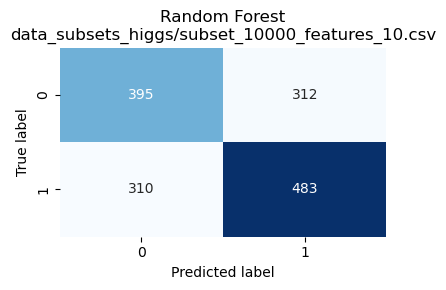

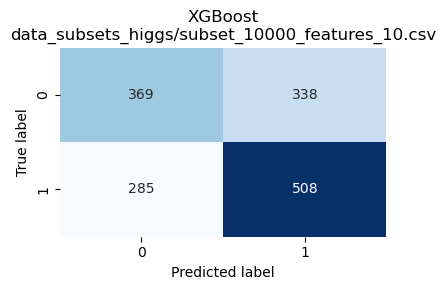

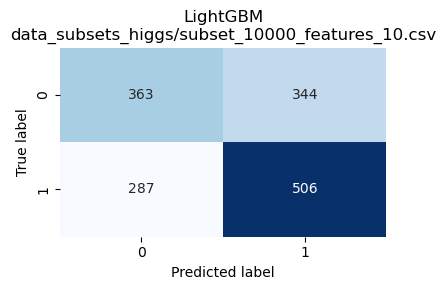

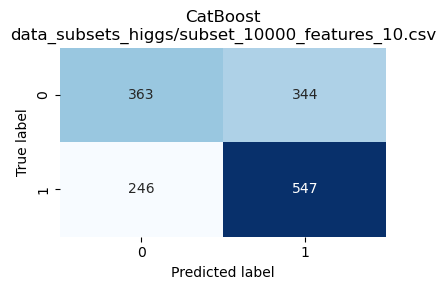

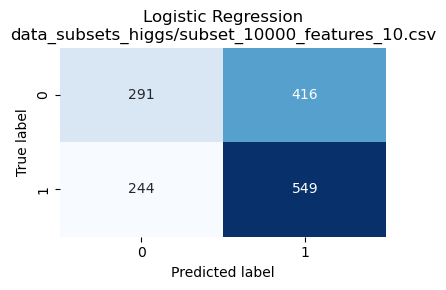

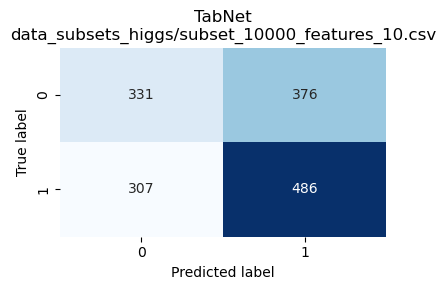

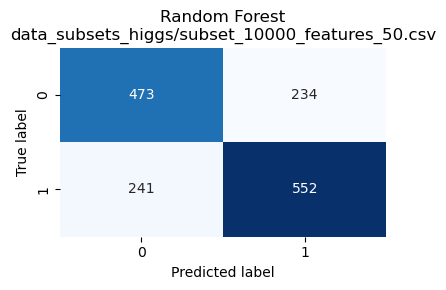

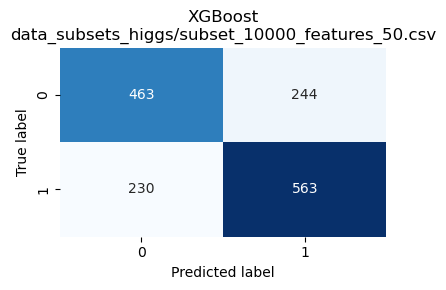

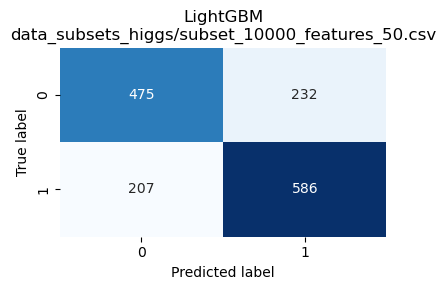

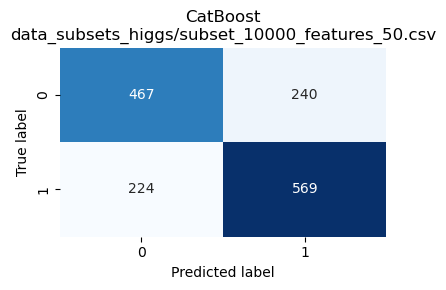

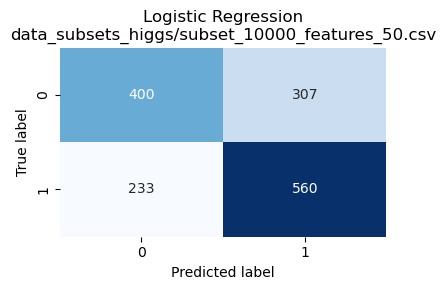

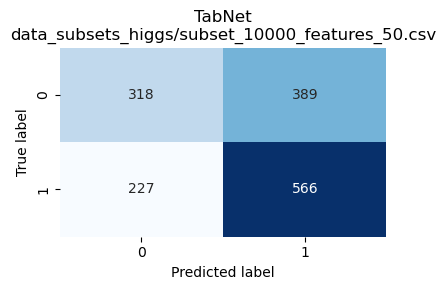

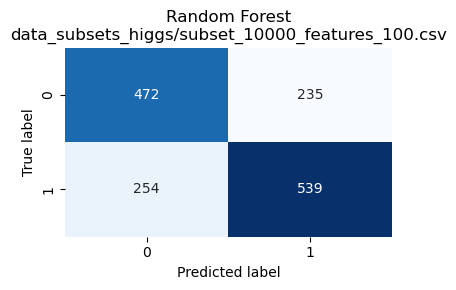

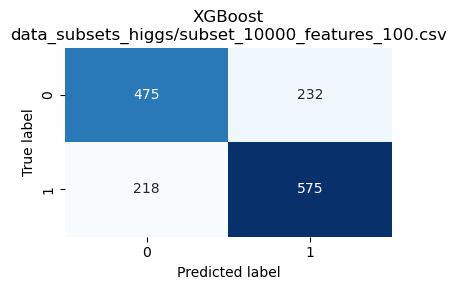

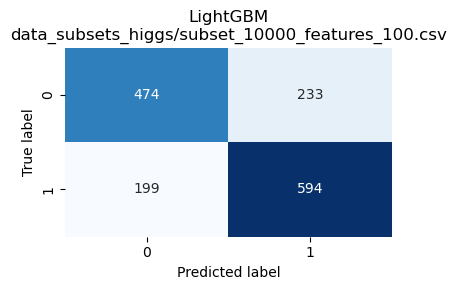

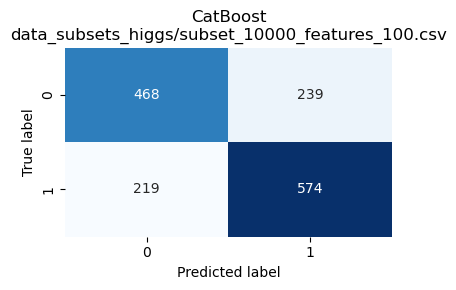

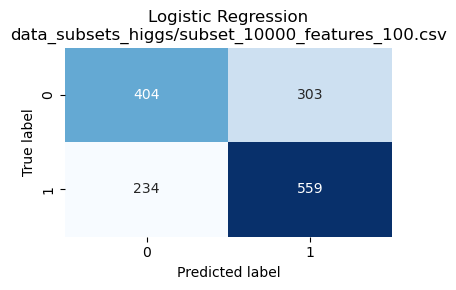

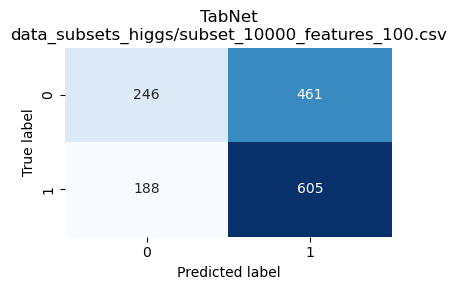

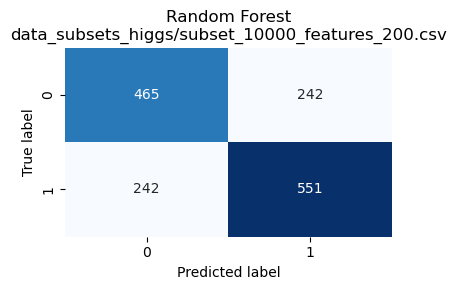

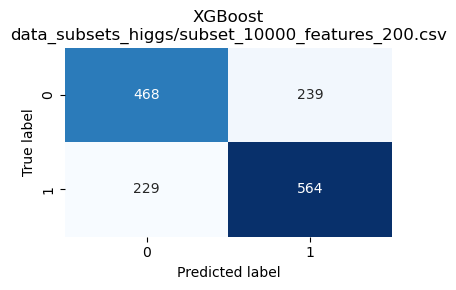

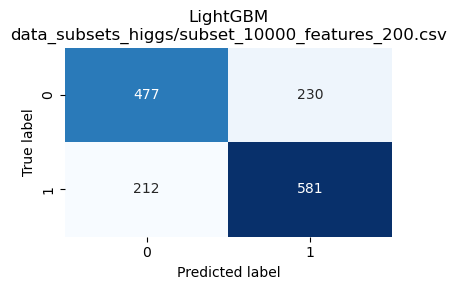

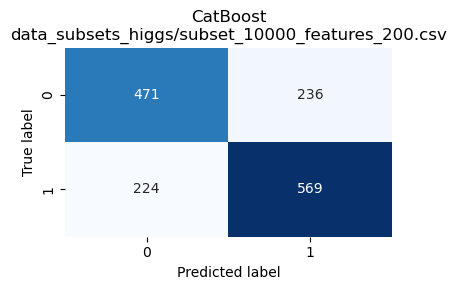

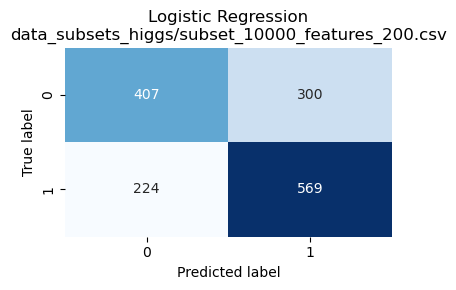

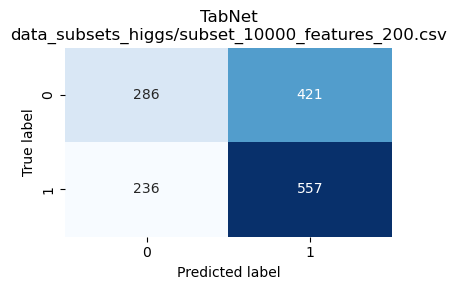

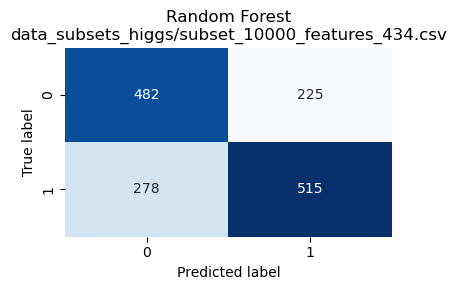

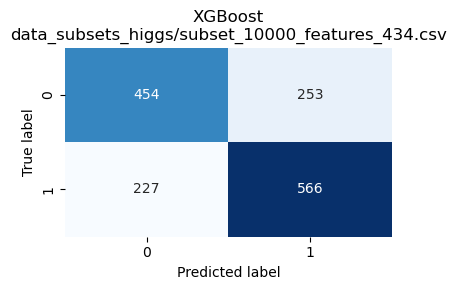

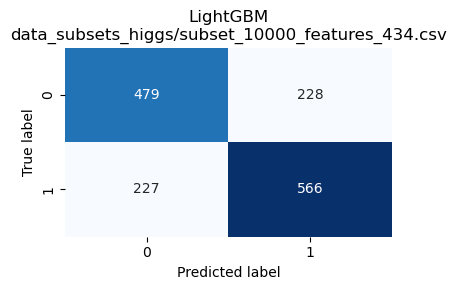

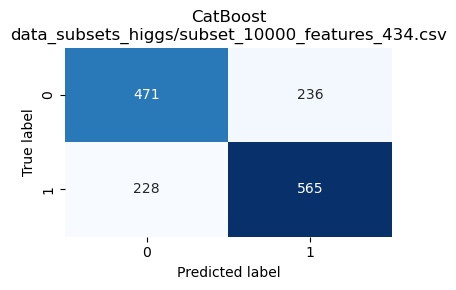

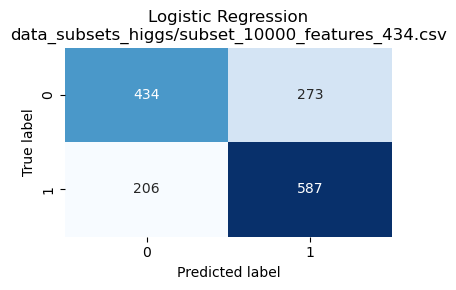

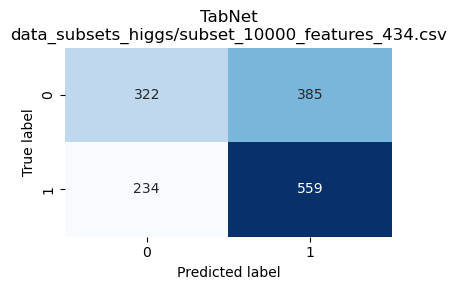

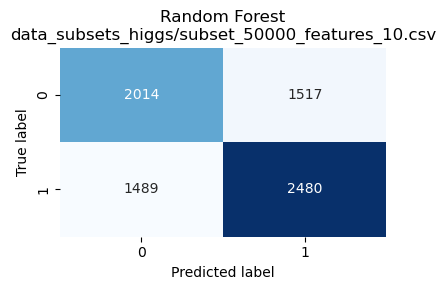

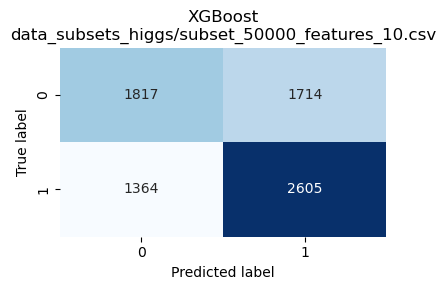

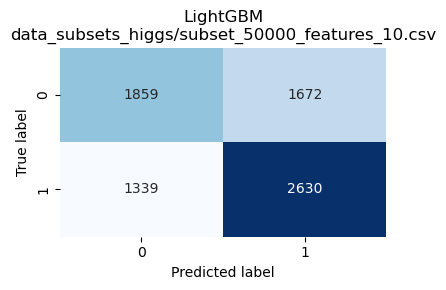

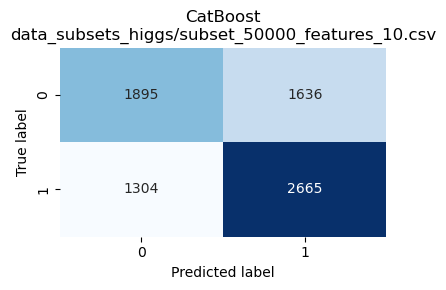

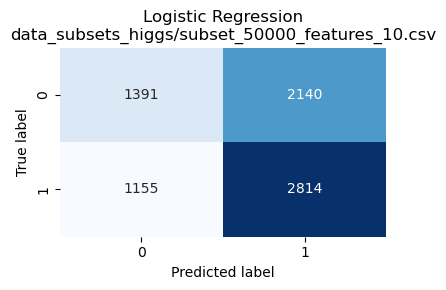

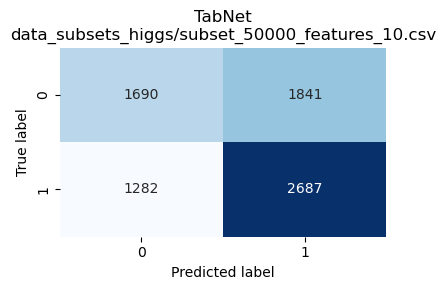

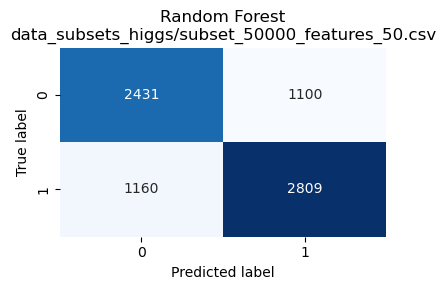

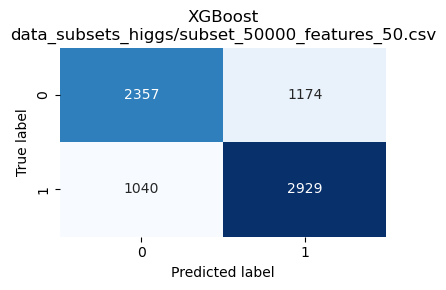

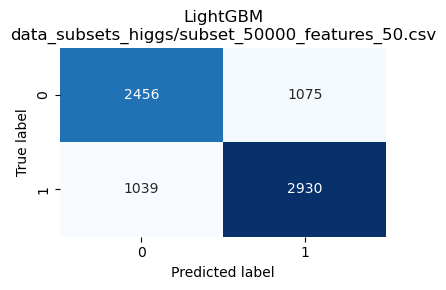

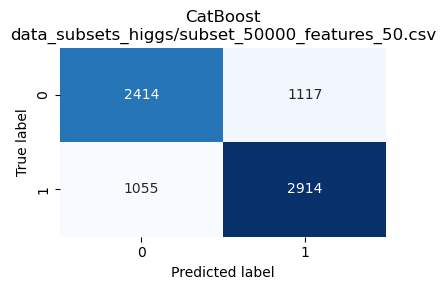

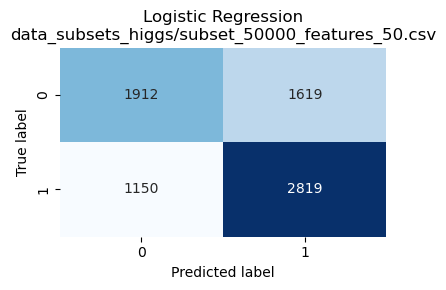

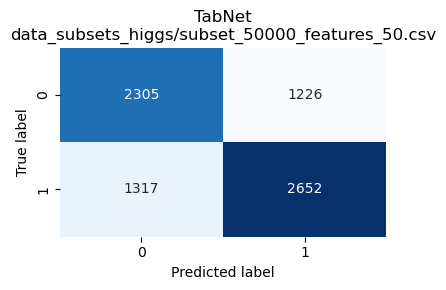

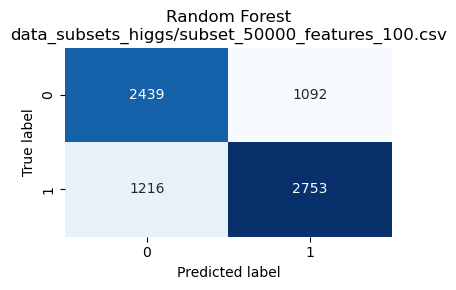

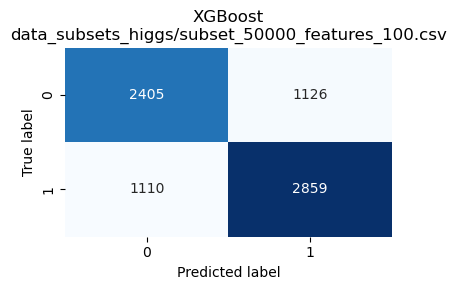

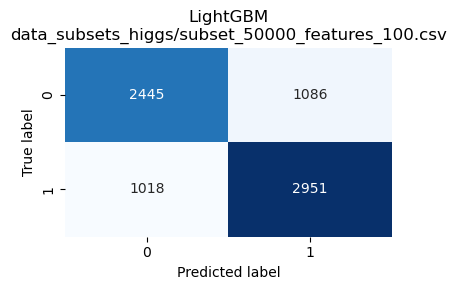

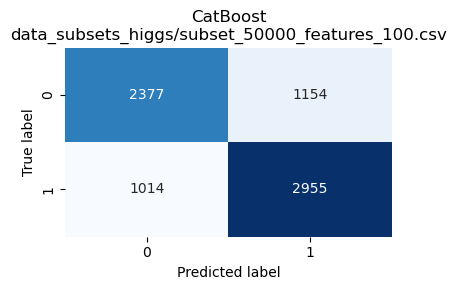

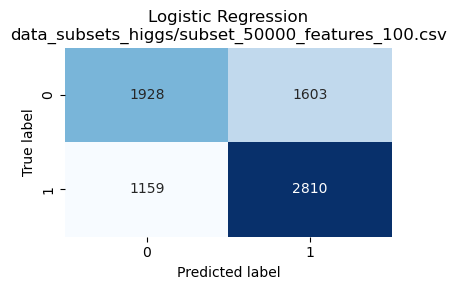

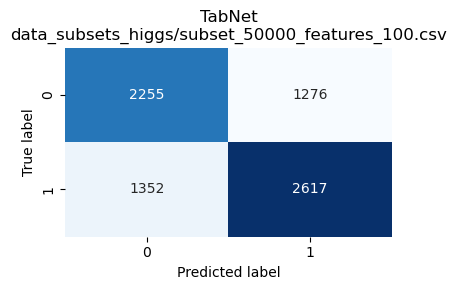

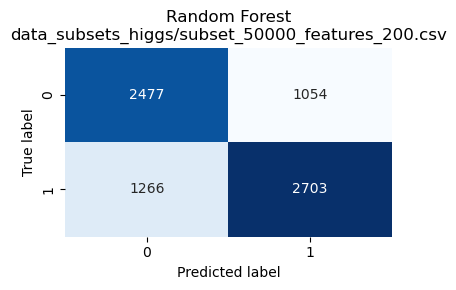

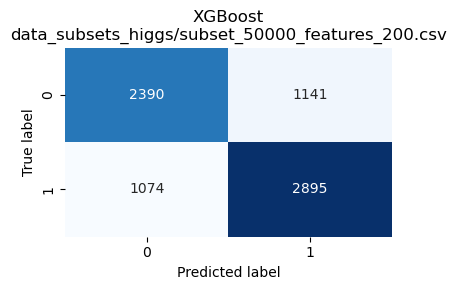

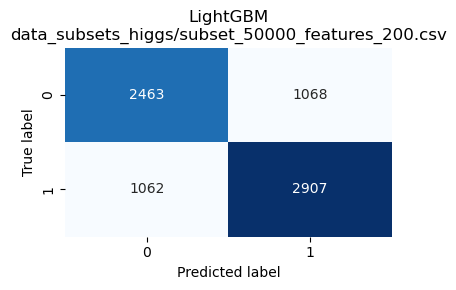

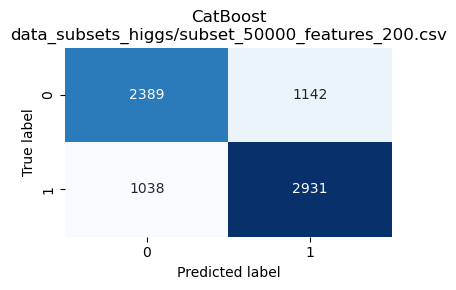

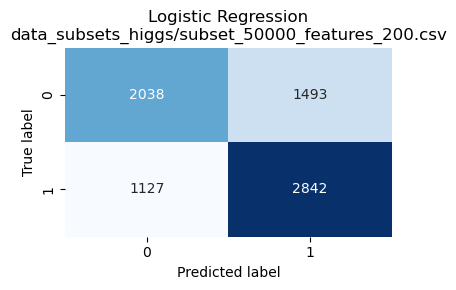

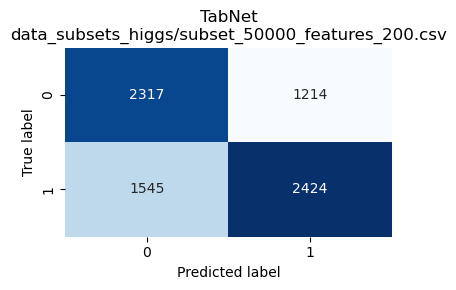

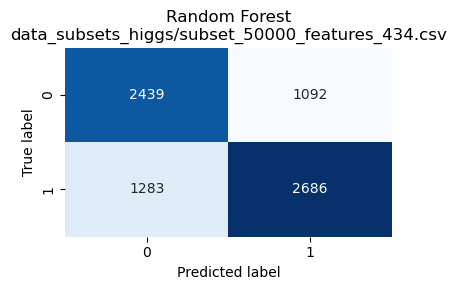

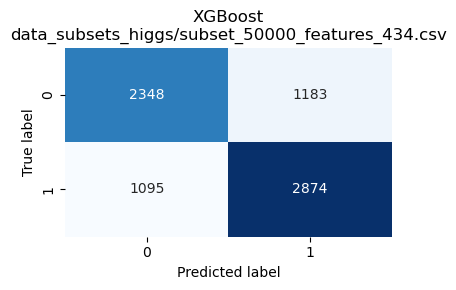

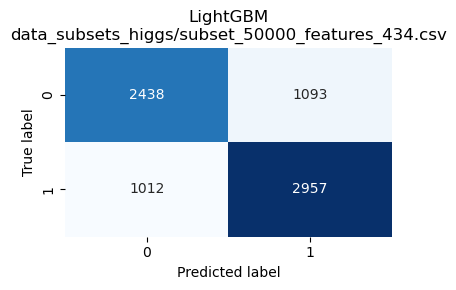

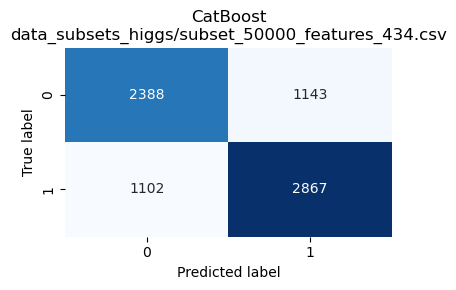

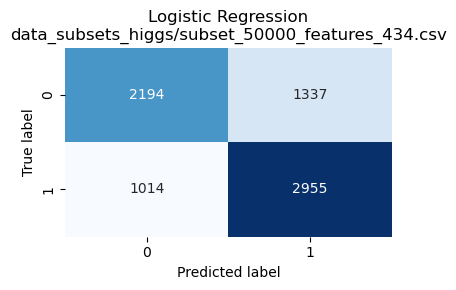

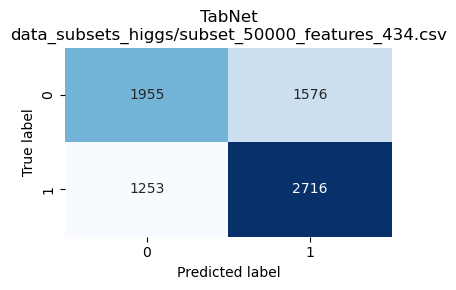

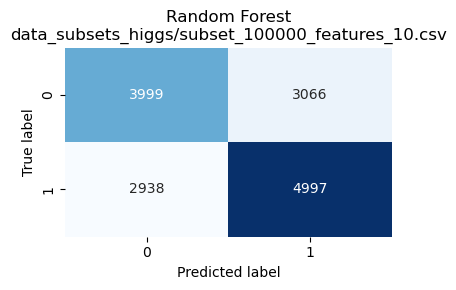

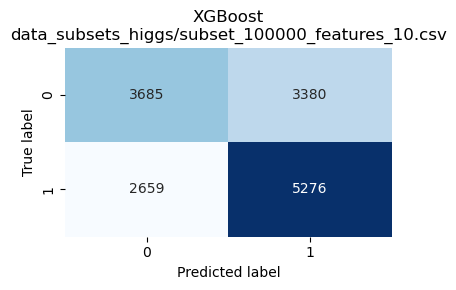

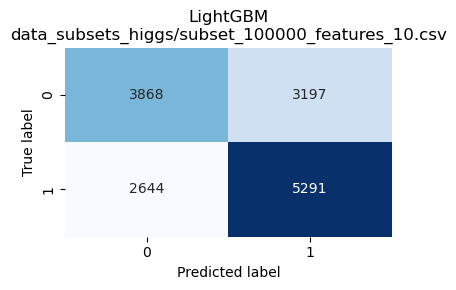

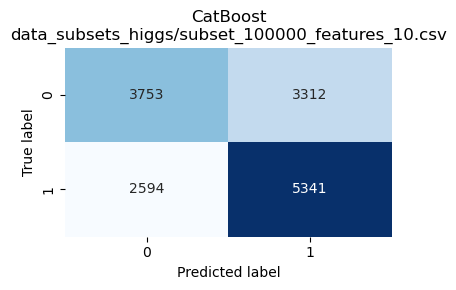

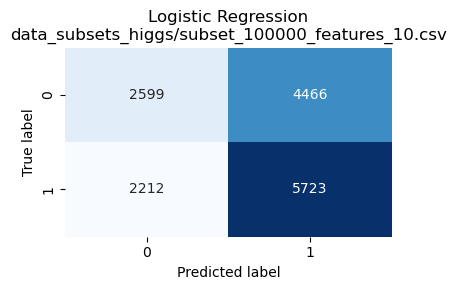

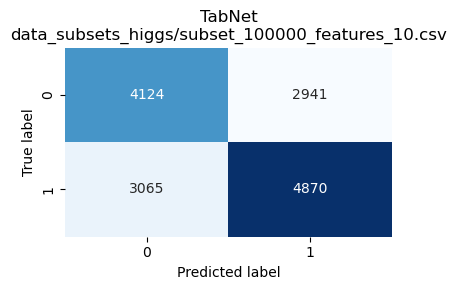

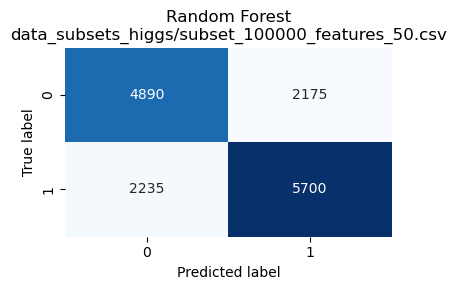

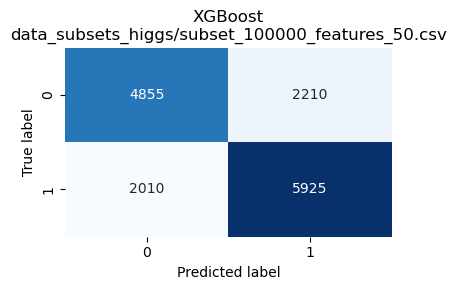

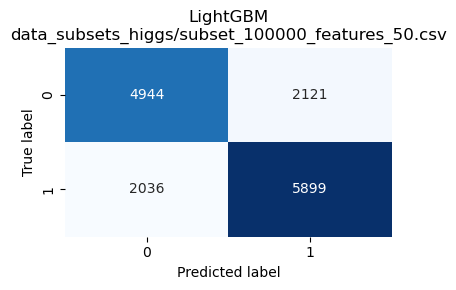

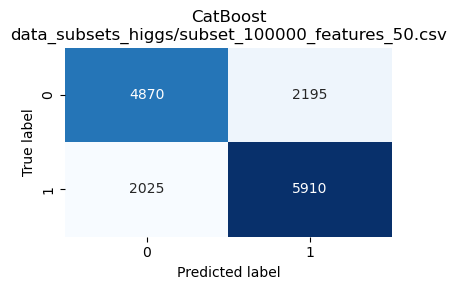

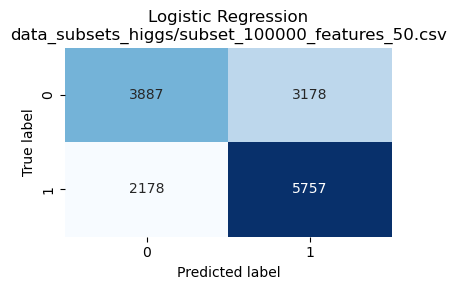

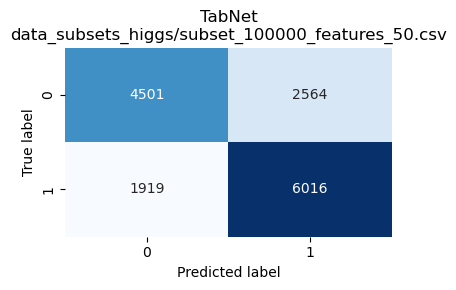

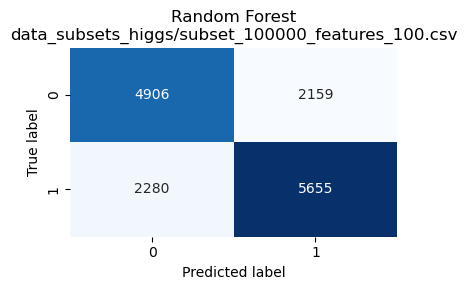

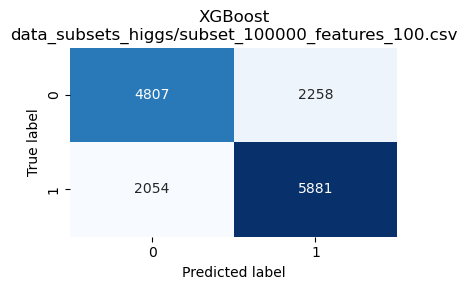

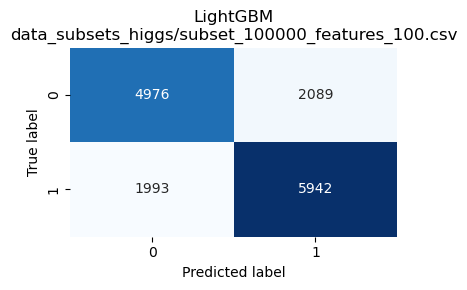

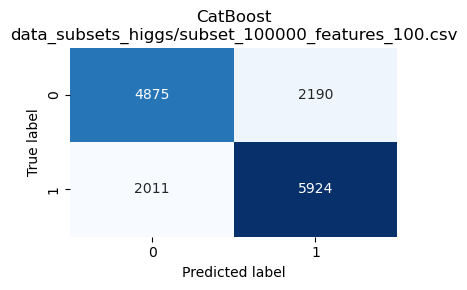

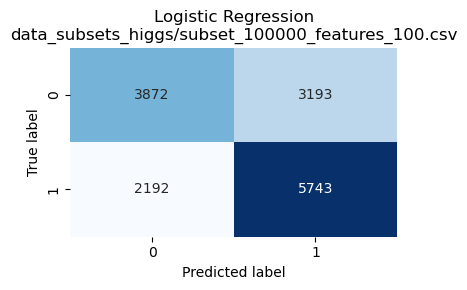

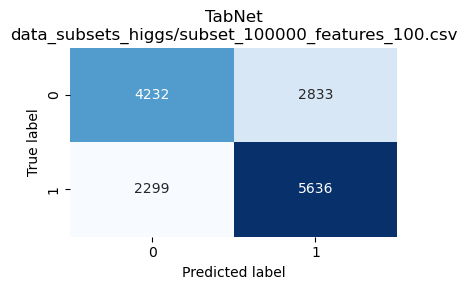

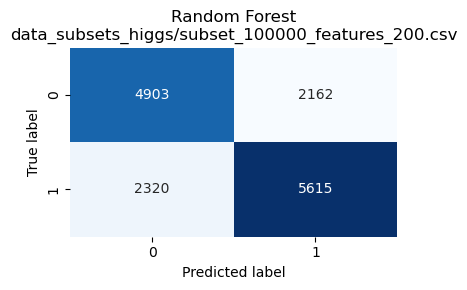

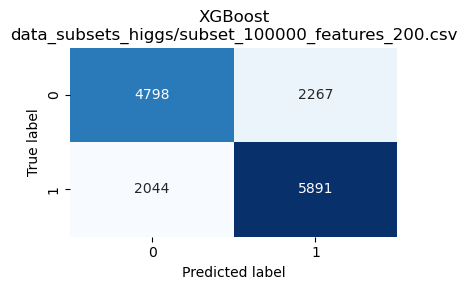

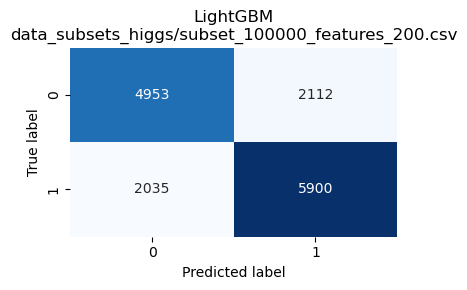

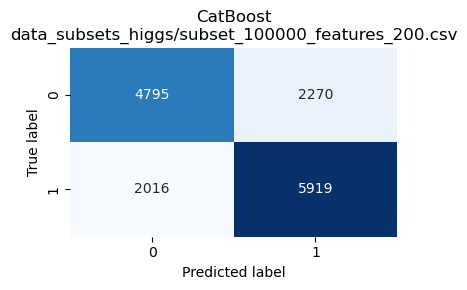

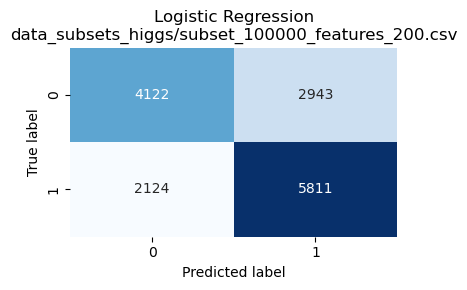

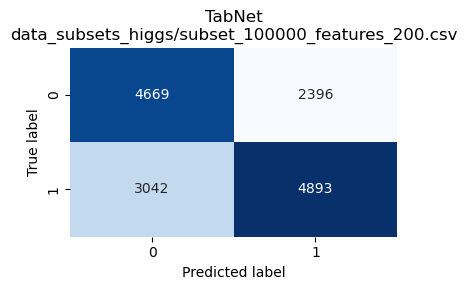

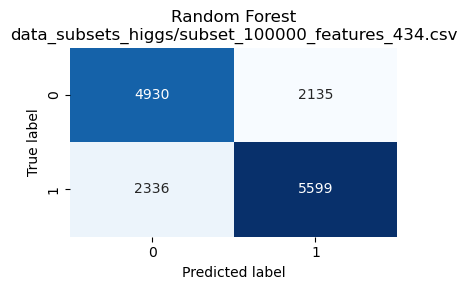

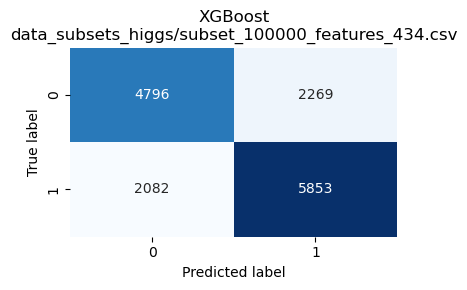

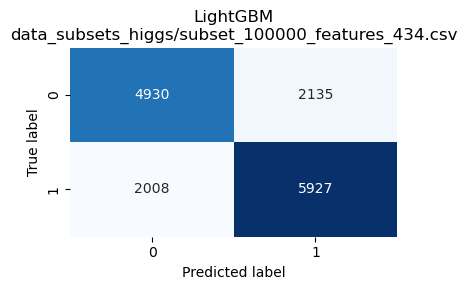

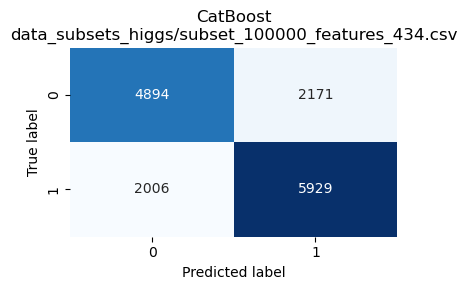

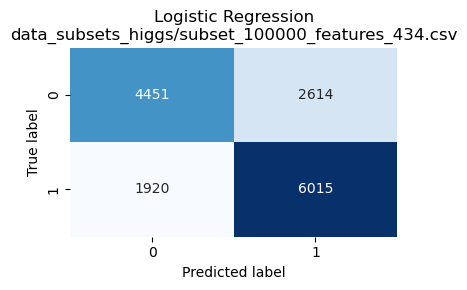

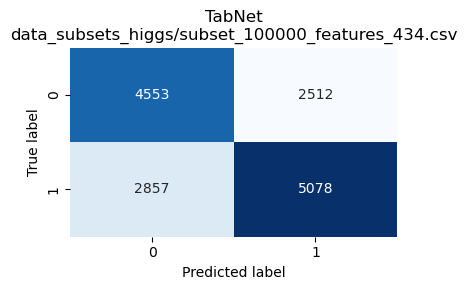

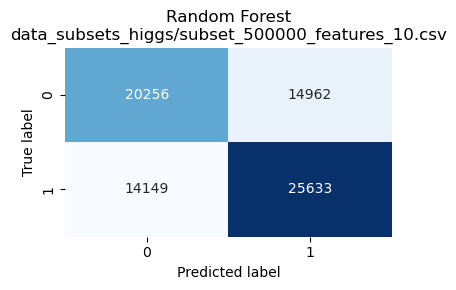

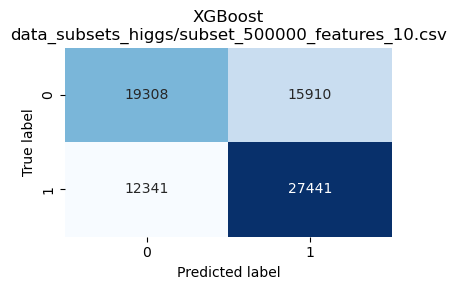

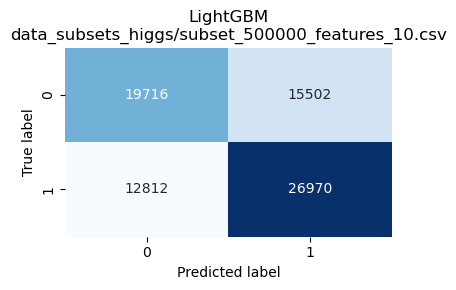

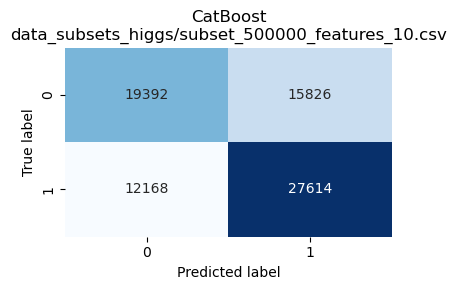

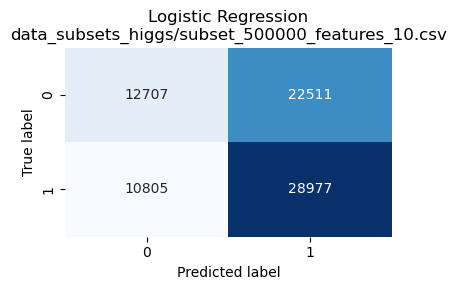

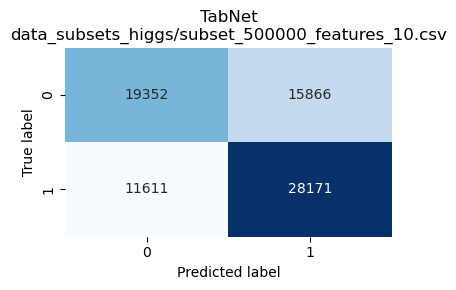

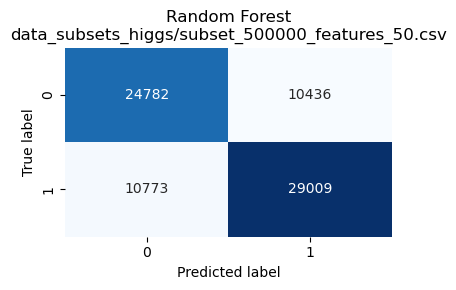

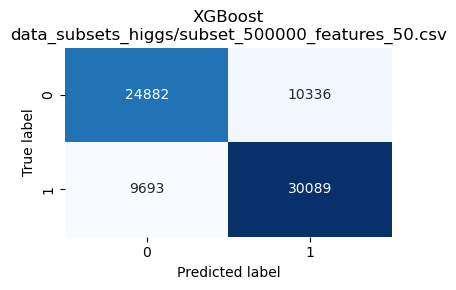

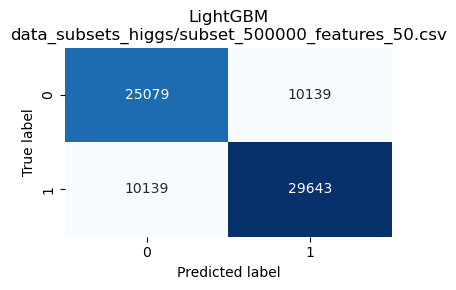

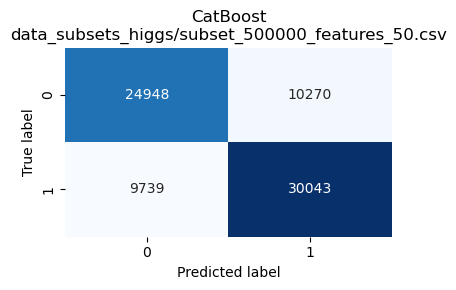

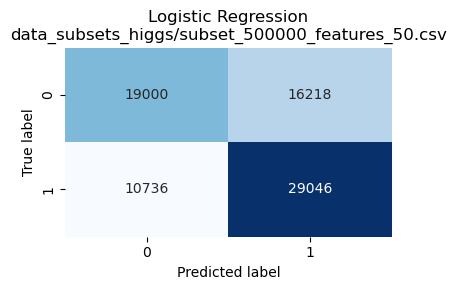

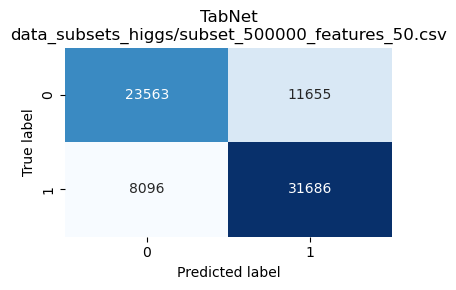

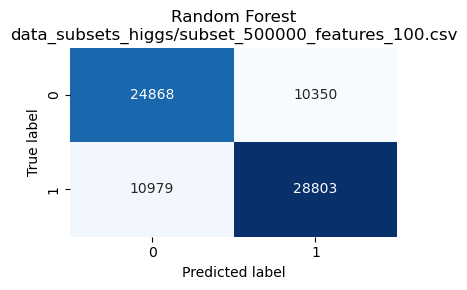

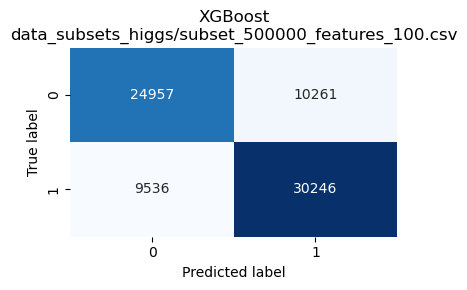

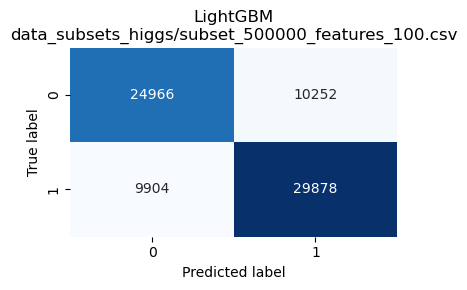

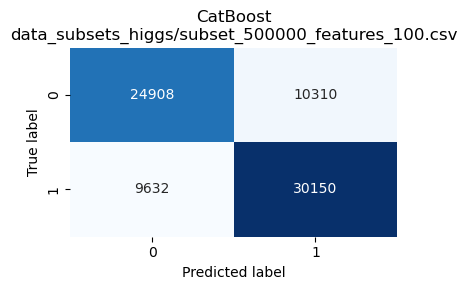

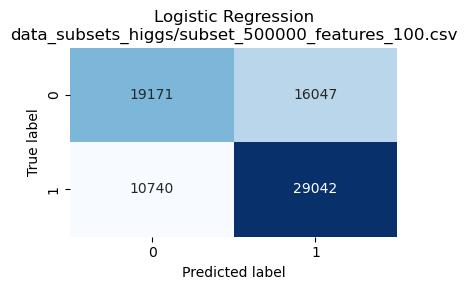

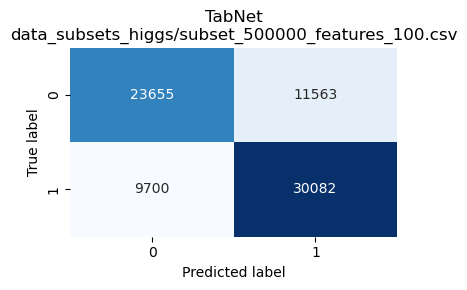

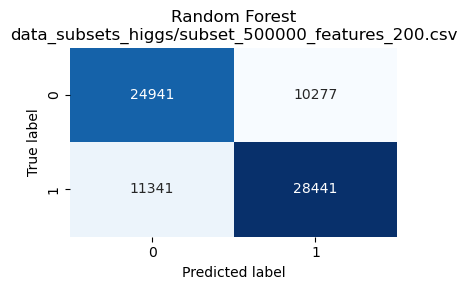

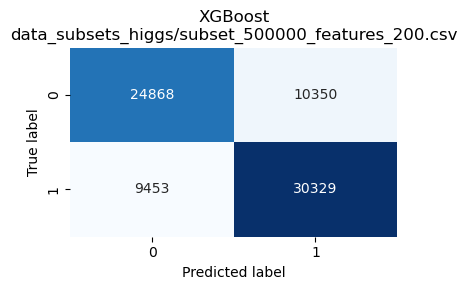

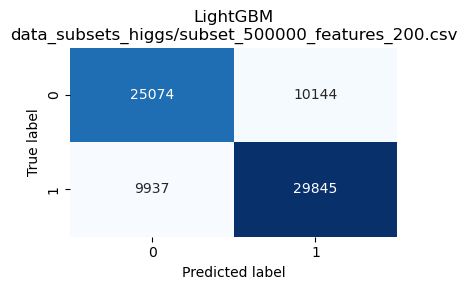

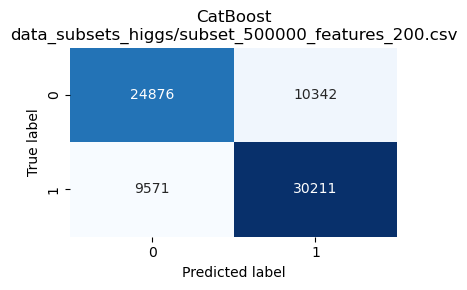

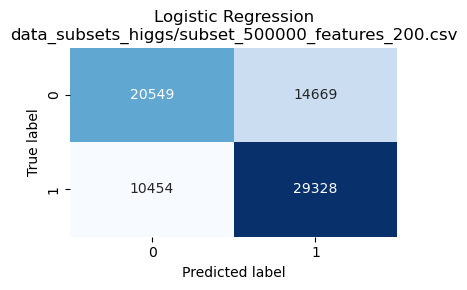

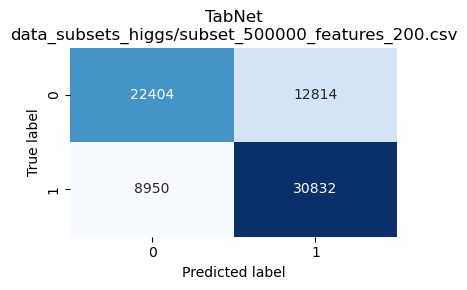

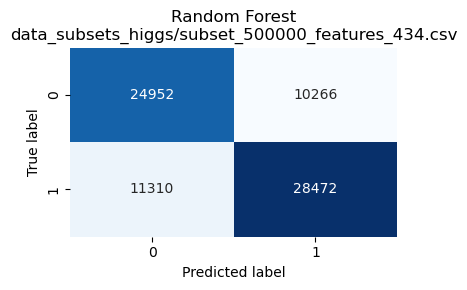

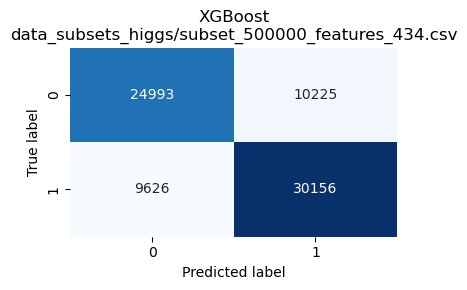

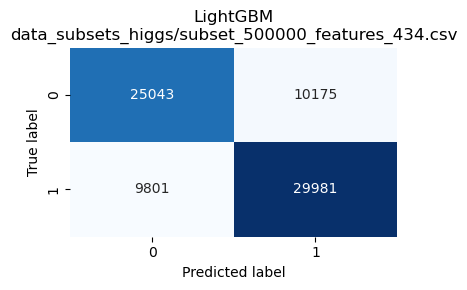

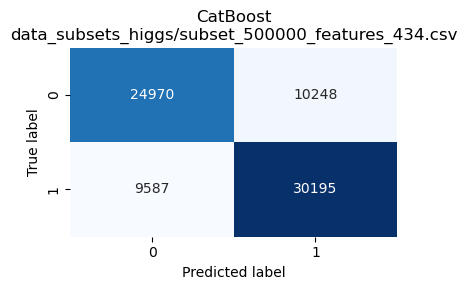

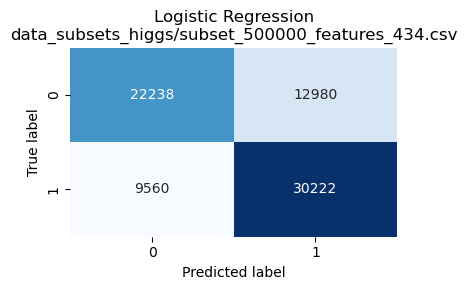

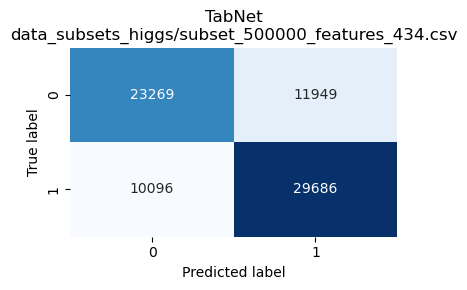

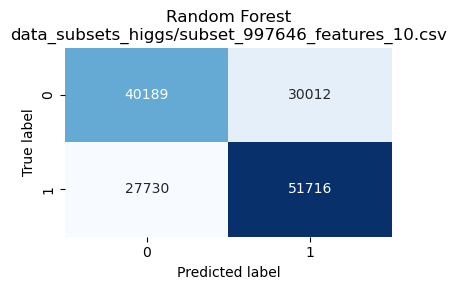

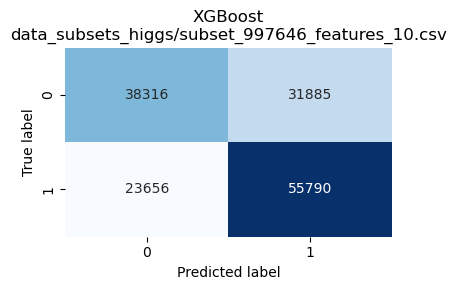

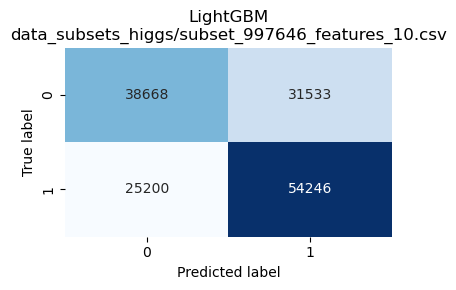

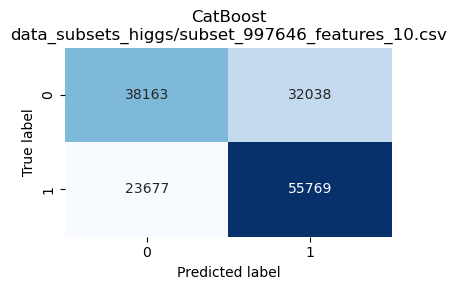

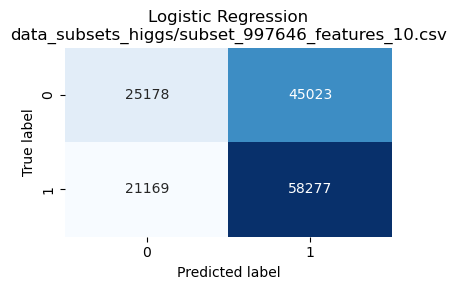

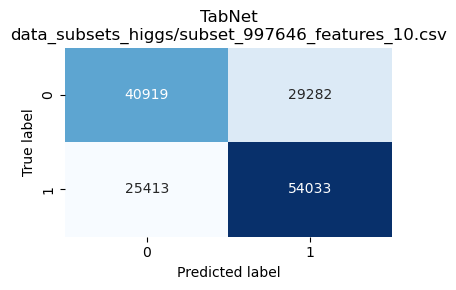

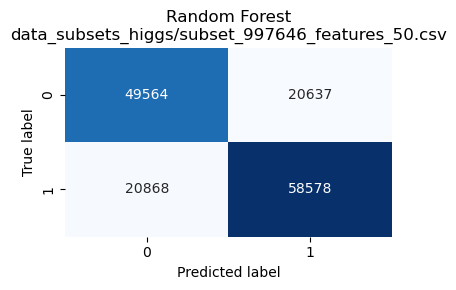

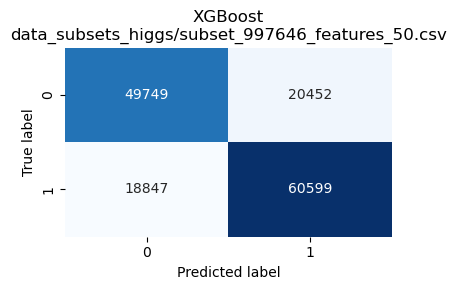

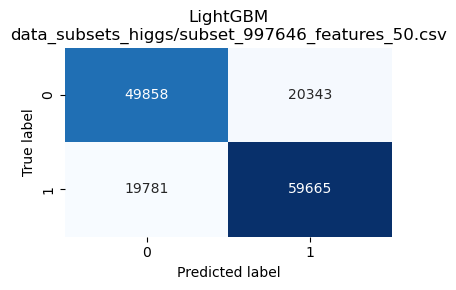

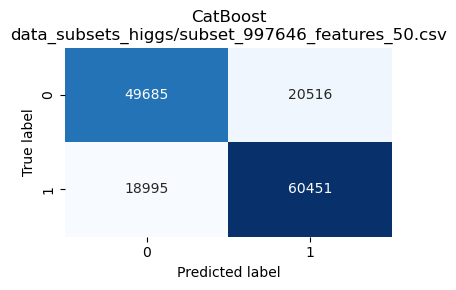

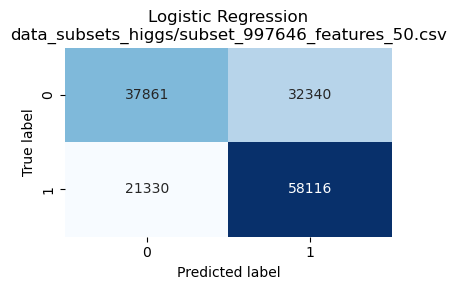

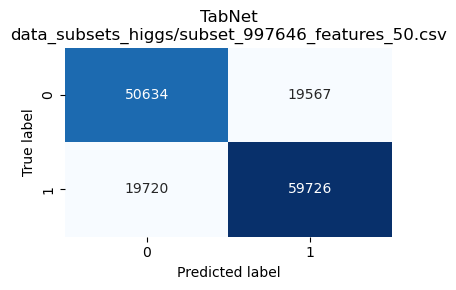

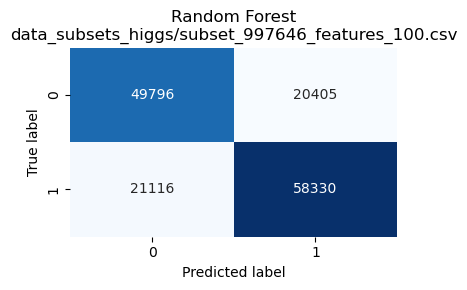

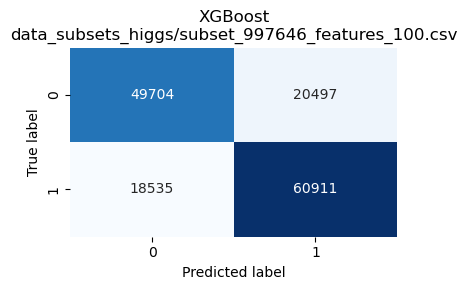

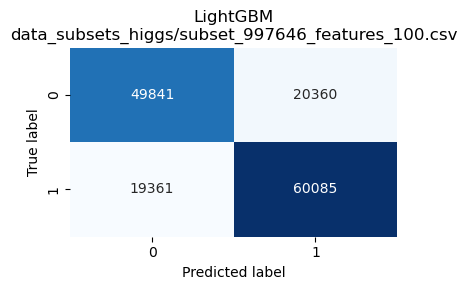

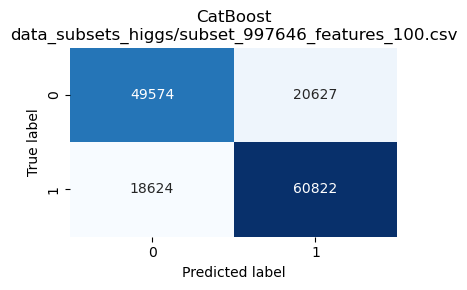

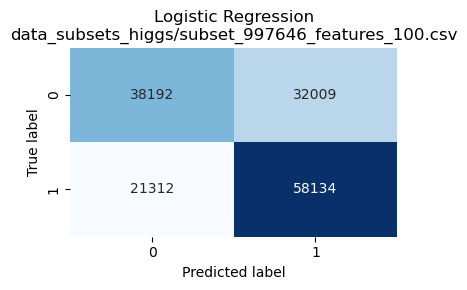

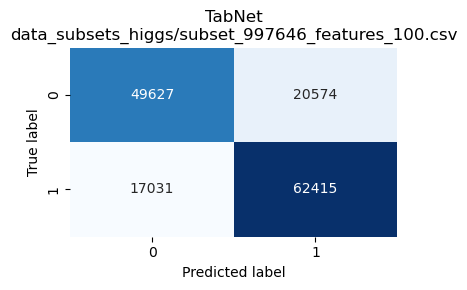

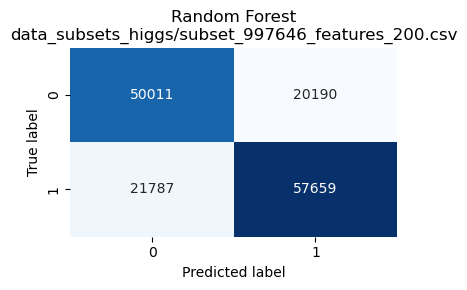

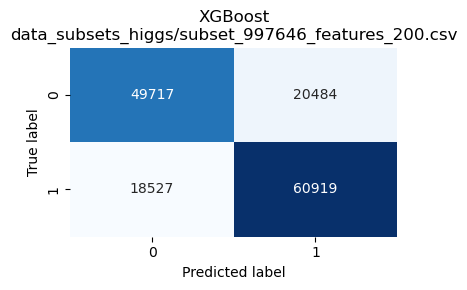

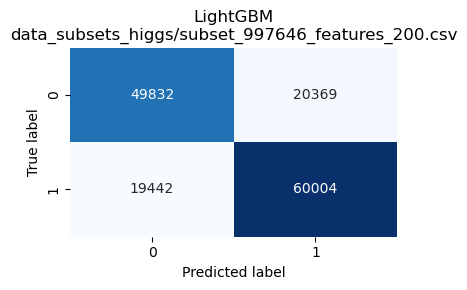

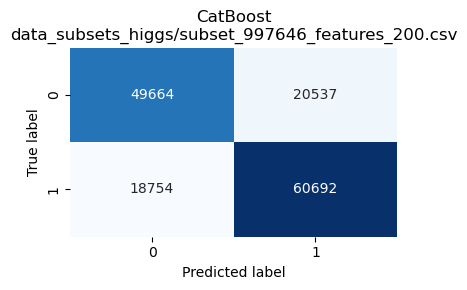

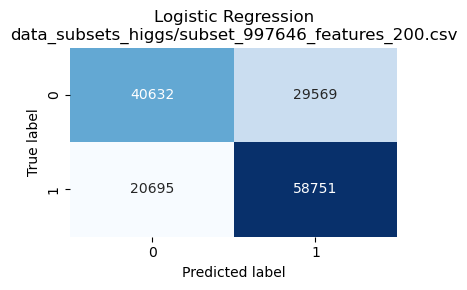

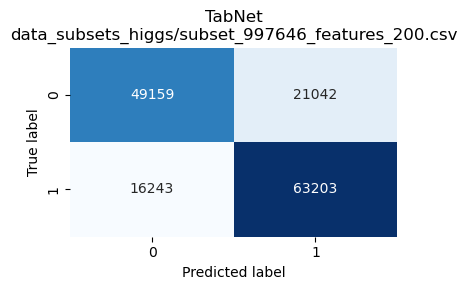

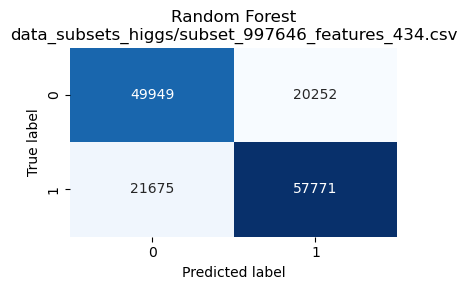

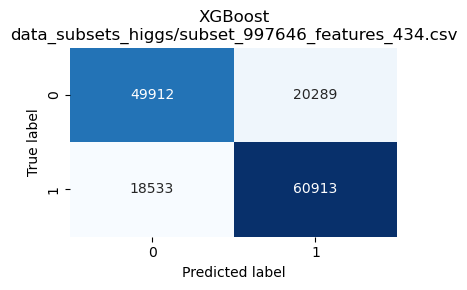

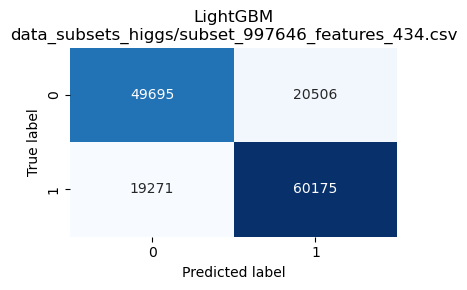

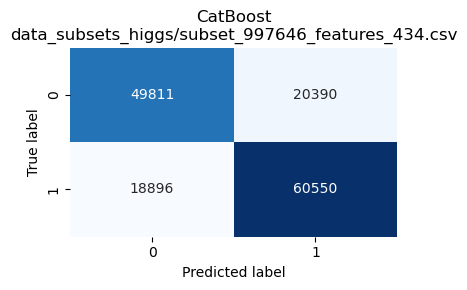

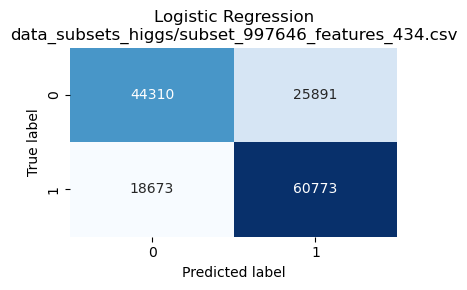

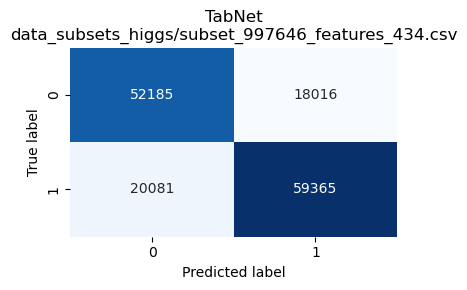

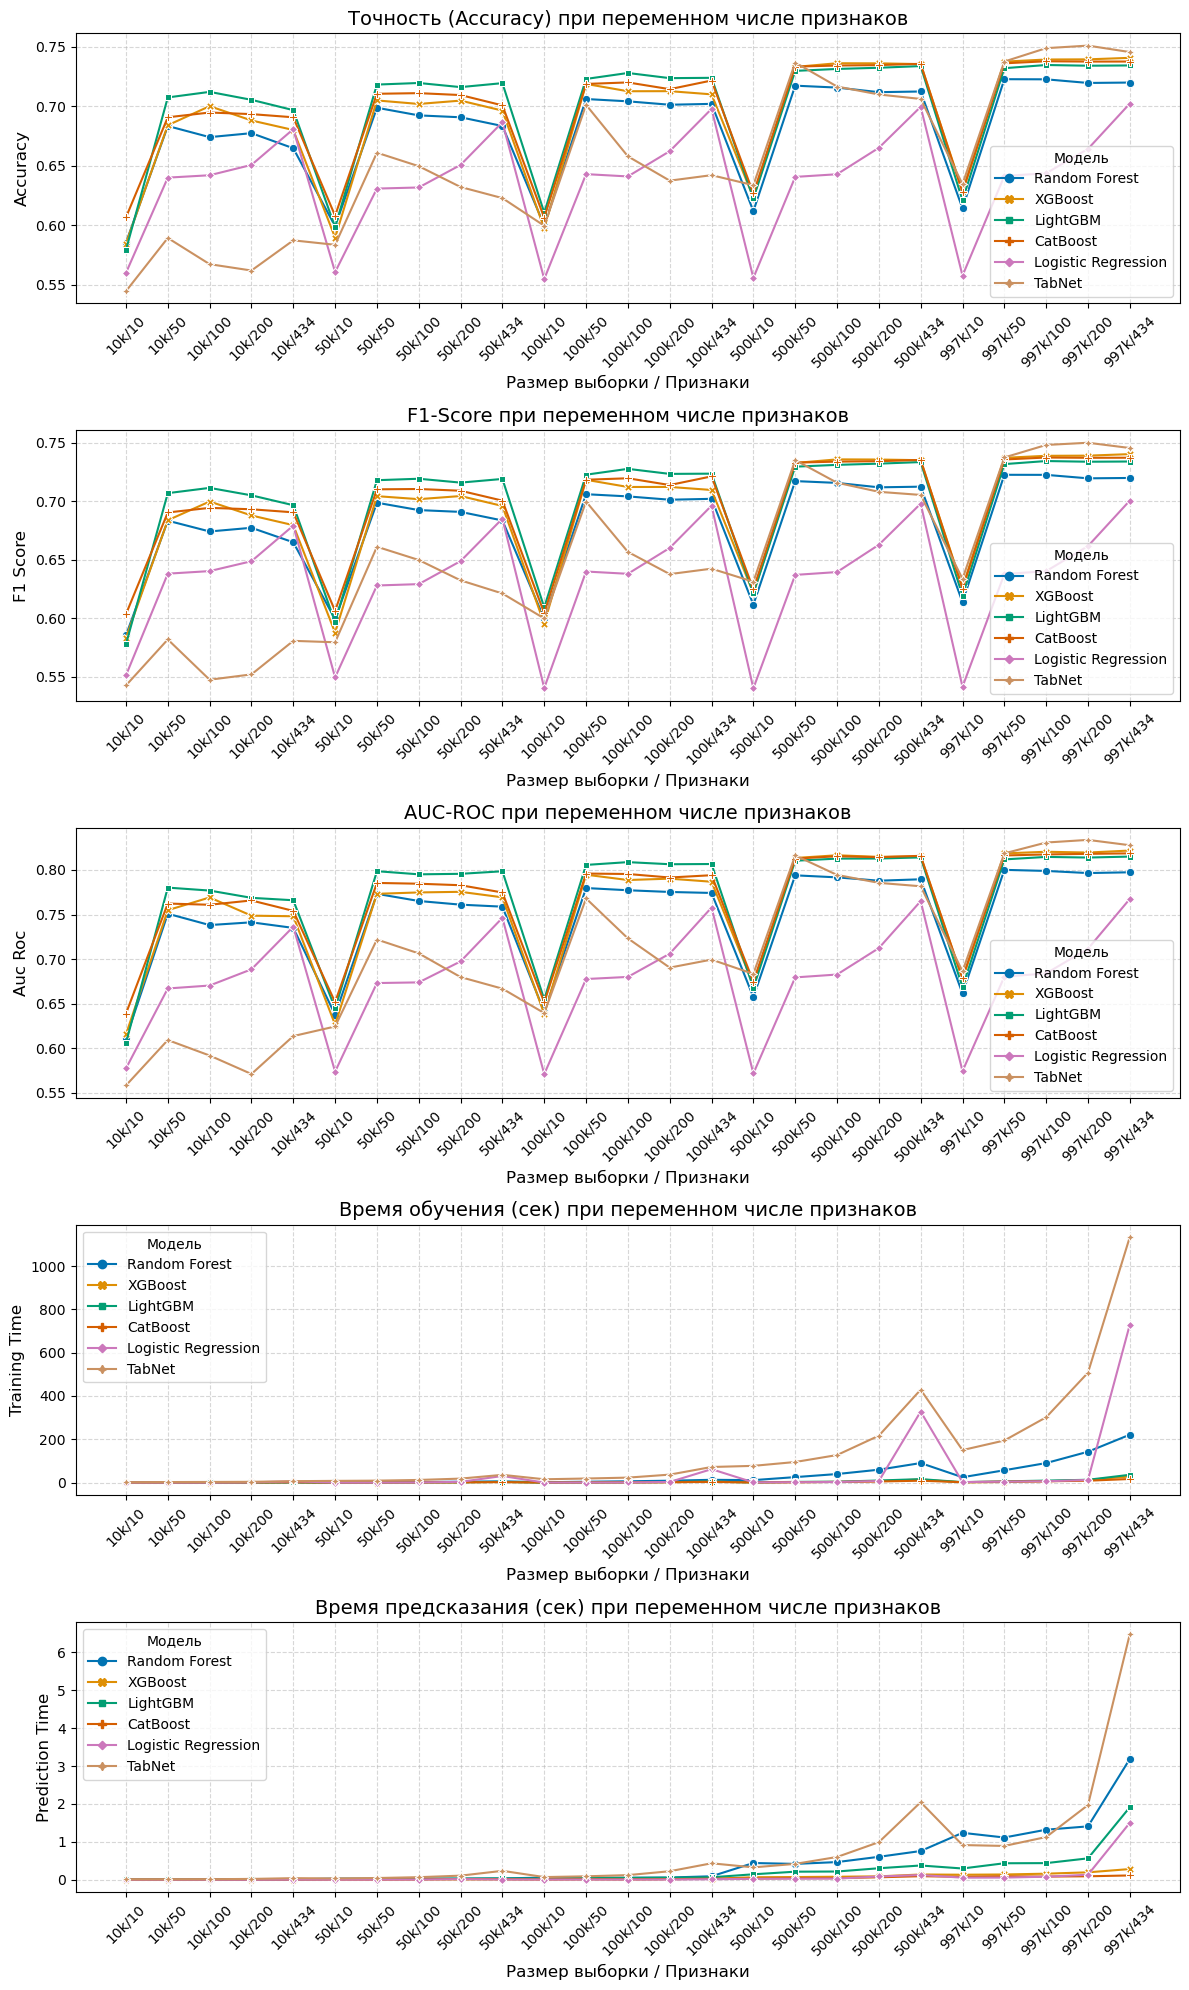

In [5]:
%matplotlib inline

results_list_2 = []
for key, value in all_results_var_features.items():
    model_name, file = key.split("_", 1)
    results_list_2.append({
        "model": model_name,
        "file": file,
        "accuracy": value["accuracy"],
        "f1_score": value["f1_score"],
        "auc_roc": value["auc_roc"],
        "training_time": value.get("training_time", None),
        "prediction_time": value.get("prediction_time", None),
        "confusion_matrix": value.get("confusion_matrix", None)
    })

results_df_2 = pd.DataFrame(results_list_2)
results_df_2 = rename_file_column(results_df_2)

print("=" * 80)
print("CONFUSION MATRICES: files_2")
print("=" * 80)

for key, value in all_results_var_features.items():
    cm = value.get("confusion_matrix", None)
    if cm is None:
        continue

    model_name, file_name = key.split("_", 1)
    plot_confusion_matrix(
        cm=cm,
        model_name=model_name,
        file_name=file_name
    )

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20))

for idx, ax in enumerate(axes):
    metric = metrics[idx]
    
    if metric not in results_df_2.columns:
        continue
    
    sns.lineplot(
        data=results_df_2,
        x='file',
        y=metric,
        hue='model',
        style='model',
        markers=True,
        dashes=False,
        palette=palette,
        ax=ax
    )
    
    ax.set_title(f"{plot_titles[idx]} при переменном числе признаков", fontsize=14)
    ax.set_xlabel('Размер выборки / Признаки', fontsize=12)
    ax.set_ylabel(metric.replace("_", " ").title(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title='Модель', loc='best')

plt.tight_layout()
plt.show()

### Итоговые таблицы (files_2)

Формируем итоговые таблицы сравнения моделей при переменном числе признаков.

In [6]:
print("Итоговые таблицы по метрикам для каждого файла (files_2)")

for metric in metrics_for_tables:
    print(f"Топ моделей по {metric.replace('_', ' ').title()}")
    
    metric_table = results_df_2[["model", "file", metric]].copy()
    metric_table = metric_table.dropna(subset=[metric])
    metric_table = metric_table.sort_values(by=metric, ascending=False)
    
    table_str = tabulate(metric_table, headers='keys', tablefmt='github', showindex=False, floatfmt=".4f")
    print(table_str)
    print("\n")

Итоговые таблицы по метрикам для каждого файла (files_2)
Топ моделей по Accuracy
| model               | file     |   accuracy |
|---------------------|----------|------------|
| TabNet              | 997k/200 |     0.7508 |
| TabNet              | 997k/100 |     0.7487 |
| TabNet              | 997k/434 |     0.7454 |
| XGBoost             | 997k/434 |     0.7406 |
| XGBoost             | 997k/200 |     0.7393 |
| XGBoost             | 997k/100 |     0.7392 |
| CatBoost            | 997k/100 |     0.7377 |
| CatBoost            | 997k/434 |     0.7375 |
| TabNet              | 997k/50  |     0.7375 |
| CatBoost            | 997k/200 |     0.7374 |
| XGBoost             | 997k/50  |     0.7374 |
| TabNet              | 500k/50  |     0.7367 |
| XGBoost             | 500k/100 |     0.7360 |
| CatBoost            | 997k/50  |     0.7360 |
| XGBoost             | 500k/200 |     0.7360 |
| CatBoost            | 500k/434 |     0.7355 |
| XGBoost             | 500k/434 |     0.7353 |
| Light